# **Import Packages and Mount Drive**

In [ ]:
#Import Packages
from __future__ import print_function
import pandas as pd
import copy
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import cycle, islice
from scipy.integrate import simps
from numpy import trapz
from itertools import islice, cycle
from tabulate import tabulate
from decimal import Decimal, ROUND_HALF_UP
from datetime import datetime


#Set Directory
import io
from google.colab import drive
drive.mount('/content/drive')
direct = "/content/drive/MyDrive/UNC_Thesis/Direct"

import os
os.chdir(direct)

# verify the path using getcwd()
cwd = os.getcwd()

# print the current directory
print("Current working directory is:", cwd)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory is: /content/drive/MyDrive/UNC_Thesis/Direct


# **Data Processing & User Inputs**

In [ ]:
#Import Datasets

#Demand import
df_demand = pd.read_csv("hrl_load_metered.csv")
df_demand.head()

#Generation import
df_gen = pd.read_csv("PJM_gen_DEC.csv")
df_gen.head()

#Power Cost Schedule
df_cost = pd.read_csv("da_hrl_lmps.csv")
df_cost.head()

#Local Emissions Rate from eGrid
df_emissions = pd.read_excel(io="eGRID2021_data.xlsx",sheet_name="BA21",skiprows=1,keep_default_na=False)


In [ ]:
def convert_time_format(timestamp):
    # Convert string to datetime object
    dt_object = datetime.strptime(timestamp, '%m/%d/%Y %H:%M')
    # Format the datetime object as desired
    formatted_time = dt_object.strftime('%#m/%-d/%Y %-I %p').replace('AM', 'a.m.').replace('PM', 'p.m.') + ' EST'
    return formatted_time


# Apply the function to the column containing timestamps
df_demand['Timestamp_hr_ending'] = df_demand['Timestamp_hr_ending_FIRST'].apply(convert_time_format)

# Save the updated dataframe to a new CSV file
df_demand.to_csv('updated_file.csv', index=False)

print(df_demand.head())

  datetime_beginning_utc Timestamp_hr_ending_FIRST nerc_region mkt_region  \
0         12/1/2023 5:00            12/1/2023 0:00         RTO        RTO   
1         12/1/2023 6:00            12/1/2023 1:00         RTO        RTO   
2         12/1/2023 7:00            12/1/2023 2:00         RTO        RTO   
3         12/1/2023 8:00            12/1/2023 3:00         RTO        RTO   
4         12/1/2023 9:00            12/1/2023 4:00         RTO        RTO   

  zone load_area  Demand_MWh  is_verified    Timestamp_hr_ending  
0  RTO       RTO   83745.928        False  12/1/2023 12 a.m. EST  
1  RTO       RTO   81889.818        False   12/1/2023 1 a.m. EST  
2  RTO       RTO   81169.032        False   12/1/2023 2 a.m. EST  
3  RTO       RTO   81517.606        False   12/1/2023 3 a.m. EST  
4  RTO       RTO   83283.419        False   12/1/2023 4 a.m. EST  


In [ ]:
# Display data types of columns in each DataFrame
print("Data types of columns in df_demand:")
print(df_demand.dtypes)

print("\nData types of columns in df_gen:")
print(df_gen.dtypes)

Data types of columns in df_demand:
datetime_beginning_utc        object
Timestamp_hr_ending_FIRST     object
nerc_region                   object
mkt_region                    object
zone                          object
load_area                     object
Demand_MWh                   float64
is_verified                     bool
Timestamp_hr_ending           object
dtype: object

Data types of columns in df_gen:
Region_Code                   object
Timestamp_hr_ending           object
Wind_Generation_MWh            int64
Solar_Generation_MWh           int64
Hydro_Generation_MWh           int64
Other_Generation_MWh           int64
Petroleum_Generation_MWh       int64
Natural_gas_Generation_MWh     int64
Coal_Generation_MWh            int64
Nuclear_Generation_MWh         int64
dtype: object


In [ ]:
# Sum fossil fuel generation
df_gen['Fossil_Fuel_Generation_MWh'] = df_gen['Petroleum_Generation_MWh'] + df_gen['Natural_gas_Generation_MWh'] + df_gen['Coal_Generation_MWh']

# Sum total generation
df_gen['Total_Generation_MWh'] = df_gen['Wind_Generation_MWh'] + df_gen['Solar_Generation_MWh'] + df_gen['Hydro_Generation_MWh'] + df_gen['Other_Generation_MWh'] + df_gen['Fossil_Fuel_Generation_MWh'] + df_gen['Nuclear_Generation_MWh']

# Calculate percentage and convert to int64
df_gen['Fossil_Fuel_Percentage'] = (df_gen['Fossil_Fuel_Generation_MWh'] / df_gen['Total_Generation_MWh'])
df_gen['Fossil_Fuel_Percentage'] = df_gen['Fossil_Fuel_Percentage'].round(2)

print(df_gen)

    Region_Code     Timestamp_hr_ending  Wind_Generation_MWh  \
0           PJM   12/1/2023 12 a.m. EST                 7039   
1           PJM    12/1/2023 1 a.m. EST                 3332   
2           PJM    12/1/2023 2 a.m. EST                 2706   
3           PJM    12/1/2023 3 a.m. EST                 3169   
4           PJM    12/1/2023 4 a.m. EST                 4119   
..          ...                     ...                  ...   
740         PJM   12/31/2023 8 p.m. EST                 4537   
741         PJM   12/31/2023 9 p.m. EST                 4602   
742         PJM  12/31/2023 10 p.m. EST                 4726   
743         PJM  12/31/2023 11 p.m. EST                 4312   
744         PJM    1/1/2024 12 a.m. EST                 4020   

     Solar_Generation_MWh  Hydro_Generation_MWh  Other_Generation_MWh  \
0                       7                   758                  1042   
1                       7                   875                  1013   
2           

In [ ]:


# Convert 'Timestamp_hr_ending' column to string in df_demand
df_demand['Timestamp_hr_ending'] = df_demand['Timestamp_hr_ending'].astype(str)

# Merge the DataFrames based on the "Timestamp_hr_ending" column
df_merged_gen_dem = pd.merge(df_demand, df_gen, on="Timestamp_hr_ending", how="inner")

print(df_merged_gen_dem)



    datetime_beginning_utc Timestamp_hr_ending_FIRST nerc_region mkt_region  \
0           12/1/2023 5:00            12/1/2023 0:00         RTO        RTO   
1           12/1/2023 6:00            12/1/2023 1:00         RTO        RTO   
2           12/1/2023 7:00            12/1/2023 2:00         RTO        RTO   
3           12/1/2023 8:00            12/1/2023 3:00         RTO        RTO   
4           12/1/2023 9:00            12/1/2023 4:00         RTO        RTO   
..                     ...                       ...         ...        ...   
739          1/1/2024 0:00          12/31/2023 19:00         RTO        RTO   
740          1/1/2024 1:00          12/31/2023 20:00         RTO        RTO   
741          1/1/2024 2:00          12/31/2023 21:00         RTO        RTO   
742          1/1/2024 3:00          12/31/2023 22:00         RTO        RTO   
743          1/1/2024 4:00          12/31/2023 23:00         RTO        RTO   

    zone load_area  Demand_MWh  is_verified     Tim

In [ ]:
# Sum fossil fuel generation
df_gen['Fossil_Fuel_Generation_MWh'] = df_gen['Petroleum_Generation_MWh'] + df_gen['Natural_gas_Generation_MWh'] + df_gen['Coal_Generation_MWh']

# Sum total generation
df_gen['Total_Generation_MWh'] = df_gen['Wind_Generation_MWh'] + df_gen['Solar_Generation_MWh'] + df_gen['Hydro_Generation_MWh'] + df_gen['Other_Generation_MWh'] + df_gen['Fossil_Fuel_Generation_MWh'] + df_gen['Nuclear_Generation_MWh']

# Calculate percentage
df_gen['Fossil_Fuel_Percentage'] = (df_gen['Fossil_Fuel_Generation_MWh'] / df_gen['Total_Generation_MWh'])

# Display the DataFrame with the added column
print(df_gen[[ 'Fossil_Fuel_Percentage']])

     Fossil_Fuel_Percentage
0                  0.571365
1                  0.576017
2                  0.579136
3                  0.576005
4                  0.568533
..                      ...
740                0.562035
741                0.569049
742                0.561268
743                0.565556
744                0.567089

[745 rows x 1 columns]


In [ ]:
# Calculate the average of the 'Fossil_Fuel_Generation_MWh' column
average_fossil_fuel_generation = df_gen['Fossil_Fuel_Percentage'].mean()

# Print the result
print("Average Fossil Fuel Generation (MWh):", average_fossil_fuel_generation)

Average Fossil Fuel Generation (MWh): 0.5767509077596882


In [ ]:
#Creating Dataframes of filtered data
#USER INPUTS
#change code so this is the only place you change data inputs

#Hourly Demand Data
#df_demand_code = df_demand.Demand_MWh

#Hourly Generation Data (Solar)
df_solar_gen = df_gen.Solar_Generation_MWh

#Hourly Generation Data (Wind)
df_wind_gen = df_gen.Wind_Generation_MWh

#Hourly Nuclear Generation
df_nuc_gen = df_gen.Nuclear_Generation_MWh

#Hourly Hydro Generation
df_hydro = df_gen.Hydro_Generation_MWh

df_gen["Fossil_Fuel_Percentage"] = df_gen["Fossil_Fuel_Percentage"].astype("int64")
print(df_gen.dtypes)

# Hourly GHG generation
df_GHG_gen = df_gen.drop(columns=['Solar_Generation_MWh', 'Wind_Generation_MWh', 'Nuclear_Generation_MWh', 'Hydro_Generation_MWh'])

# Convert all columns to numeric to ensure proper summation
df_GHG_gen = df_GHG_gen.apply(pd.to_numeric, errors='coerce')

# Now, sum across rows
df_GHG_gen = df_GHG_gen.sum(axis=1)

df_GHG_gen.head()

Region_Code                   object
Timestamp_hr_ending           object
Wind_Generation_MWh            int64
Solar_Generation_MWh           int64
Hydro_Generation_MWh           int64
Other_Generation_MWh           int64
Petroleum_Generation_MWh       int64
Natural_gas_Generation_MWh     int64
Coal_Generation_MWh            int64
Nuclear_Generation_MWh         int64
Fossil_Fuel_Generation_MWh     int64
Total_Generation_MWh           int64
Fossil_Fuel_Percentage         int64
dtype: object


0    214293.0
1    198886.0
2    197491.0
3    197922.0
4    197759.0
dtype: float64

In [ ]:
#Set Constants and Options

#Location
balance_auth =  "PJM"

#Dates
dates_of_data = "12/1/2023-12/31/2023"

# User Defined Bttery and Schedule Parameters
max_capacity = 281.1
stor_roundtrip_eff = 0.86 # Adjust for different battery types (e.g. 0.68 for flow battery) OR CHANGE TO DEPTH OR CHARGE 80%
charge_rate = max_capacity*.25  # Adjust as needed (in MWh)
discharge_rate = max_capacity*.25*stor_roundtrip_eff
num_intervals_per_hour = 1  # Example: There are 4 intervals in an hour (15 minutes each)
days_of_data = 32  # Number of days in the data set


#Set Generation Goal / time step
user_gg = 5000

#Set Demand Threshold
user_dt = 1000

#season
season = "winter"

# User-defined electricity prices by hour
if season == "winter":

  electricity_prices_by_hour = {
      0: 0.45,   # midnight
      1: 0.25,   # 1 AM
      2: 0.25,   # 2 AM
      3: 0.25,   # 3 AM
      4: 0.25,   # 4 AM
      5: 0.25,   # 5 AM
      6: 0.25,   # 6 AM
      7: 0.25,   # 7 AM
      8: 0.25,   # 8 AM
      9: 0.25,   # 9 AM
      10: 0.25,  # 10 AM
      11: 0.25,  # 11 AM
      12: 0.25,  # 12 PM
      13: 0.25,  # 1 PM
      14: 0.25,  # 2 PM
      15: 0.45,  # 3 PM
      16: 0.56,  # 4 PM
      17: 0.56,  # 5 PM
      18: 0.56,  # 6 PM
      19: 0.56,  # 7 PM
      20: 0.56,  # 8 PM
      21: 0.56,  # 9 PM
      22: 0.45,  # 10 PM
      23: 0.45   # 11 PM
  }

elif season == "summer":

  electricity_prices_by_hour = {
      0: 0.25,   # midnight
      1: 0.25,   # 1 AM
      2: 0.25,   # 2 AM
      3: 0.25,   # 3 AM
      4: 0.25,   # 4 AM
      5: 0.25,   # 5 AM
      6: 0.25,   # 6 AM
      7: 0.25,   # 7 AM
      8: 0.25,   # 8 AM
      9: 0.25,   # 9 AM
      10: 0.25,  # 10 AM
      11: 0.25,  # 11 AM
      12: 0.45,  # 12 PM
      13: 0.45,  # 1 PM
      14: 0.56,  # 2 PM
      15: 0.56,  # 3 PM
      16: 0.56,  # 4 PM
      17: 0.56,  # 5 PM
      18: 0.56,  # 6 PM
      19: 0.45,  # 7 PM
      20: 0.45,  # 8 PM
      21: 0.25,  # 9 PM
      22: 0.25,  # 10 PM
      23: 0.25   # 11 PM
  }
else:
  print("choose a season, summer or winter")




Functions

In [ ]:
# Convert the data into 1 dimension
def convert_oneD(data):
    return np.reshape(data, data.shape[0]*data.shape[1])

# Plot the net_load curve
def net_load(data):
    # Create an array of x-axis values for 15-minute intervals
    x = np.arange(0, len(data), 15)  # Assuming data is an array-like object

    # Calculate step size for x-ticks
    step = max(1, len(x) // 5)

    # Reshape data into one row and plot data
    plt.figure(figsize=(20, 10))
    plt.plot(data)

def net_load_24(data, start_time, end_time):
    # Assuming data is a 1D array-like object representing net load values

    # Find indices corresponding to start and end times
    start_index = start_time * 4  # Convert start time to index (assuming each data point represents 15 minutes)
    end_index = end_time * 4      # Convert end time to index

    # Create an array of x-axis values for the selected 24-hour period
    x = np.arange(start_index, end_index, 1)  # Assuming each data point represents 15 minutes

    # Calculate step size for x-ticks
    step = max(1, len(x) // 5)

    # Reshape data into one row and plot data
    plt.figure(figsize=(20, 10))
    plt.plot(x, data[start_index:end_index])  # Plotting only the selected period
    plt.xticks(np.arange(start_index, end_index, step), rotation=45)
    plt.xlabel('Time')
    plt.ylabel('Net Load')
    plt.title('Net Load Curve for Selected 24-Hour Period')
    plt.grid(True)
    plt.show()

    # Example usage:
    # Assuming data is your net load data for 24 hours
    # start_time and end_time are integers representing the start and end times in 24-hour format (e.g., 0 for midnight, 23 for 11:45 PM)



def load_duration(datasets, legend_labels=None, title=None, x_label=None, y_label=None, zoom_x_start=None, zoom_x_end=None, zoom_y_start=None, zoom_y_end=None):
    plt.figure(figsize=(20, 10))
    for i, dataset in enumerate(datasets):
        data_to_sort = copy.deepcopy(dataset)
        sorted_data = data_to_sort.sort_values(ascending=False)
        energy_data_sorted = sorted_data.reset_index(drop=True)

        # Use legend_labels if provided, otherwise default to 'Dataset i'
        label = legend_labels[i] if legend_labels and i < len(legend_labels) else f'Dataset {i+1}'

        plt.plot(energy_data_sorted, label=label)

    # Set the zoom range on the x-axis if provided
    if zoom_x_start is not None and zoom_x_end is not None:
        plt.xlim(zoom_x_start, zoom_x_end)

    # Set the zoom range on the y-axis if provided
    if zoom_y_start is not None and zoom_y_end is not None:
        plt.ylim(zoom_y_start, zoom_y_end)

    plt.legend()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


# sort data decrementally
def sort_data(data):
    data_to_sort = copy.deepcopy(data)
    data_to_sort.sort()
    data_sorted = data_to_sort[::-1]
    return data_sorted

# Calculate the area beneath the curve
def calculate_area(data):
    return simps(data, dx=5)


# Calculate emission coal, NG, nuclear
def calculate_emission(coal_energy_usage, NG_energy_usage, nuclear_energy_usage):
    coal_emisson_per_kw = 0.34
    NG_emission_per_kw = 0.20
    nuclear_emission_per_kw = 0.04
    return 0.34*coal_energy_usage*1000+0.20*NG_energy_usage*1000+0.04*nuclear_energy_usage*1000

def generate_price_list(prices_by_hour, num_items):
    # Create a cycle iterator for the prices
    cycle_iter = cycle(prices_by_hour.values())

    # Initialize the count variable
    count = 0

    # Initialize the list to store the generated prices
    price_list = []

    # Iterate to generate the list
    for _ in range(num_items):
        current_price = next(cycle_iter)

        # If it's the first item, update count
        if count == 0:
            count += 1

        # Append the current price to the list
        price_list.append(current_price)

    return price_list


# **Charging Schedules**

**Fixed Charging Schedule**

In [ ]:
battery_state = pd.DataFrame(index=range(1, 25 * days_of_data + 1), columns=['State'])

# Set initial state to fully charged
battery_state['State'] = 0

# Initialize array to track net charge or discharge, previous state, and battery charge
net_charge_discharge = []
previous_state_values = []
battery_charge_values = []

#Initalize array to track renew charge
charge_renew = []

# Initialize a counter for the number of zeros
zero_count = 0

# Run for each hour in the simulation
for i in range(2, 24 * days_of_data + 1):

    current_day = (i - 1) % 24 + 1  # Calculate the current day

    if i == 0:
        # For the first hour, use the initial state
        prev_state = battery_state['State'].iloc[0]
    else:
        prev_state = battery_state['State'].iloc[i - 1]

    if (2 <= i % 24 <= 10 or 18 <= i % 24 <= 25) and (prev_state > 0):
        # Discharging
        discharge_amount = min(discharge_rate, prev_state)
        battery_state['State'].iloc[i] = max(0, prev_state - discharge_amount)

        # Divide the discharge_amount by num_intervals_per_hour and append it to the array
        divided_amount = discharge_amount / num_intervals_per_hour
        net_charge_discharge.extend([-divided_amount] * num_intervals_per_hour)
        charge_renew.append(0)

    elif (prev_state < max_capacity) and (11 <= i % 24 <= 17):
        # Charging
        charge_amount = min(charge_rate, max_capacity - prev_state)
        battery_state['State'].iloc[i] = min(max_capacity, prev_state + charge_amount)

        # Divide the charge_amount by num_intervals_per_hour and append it to the array
        divided_amount = charge_amount / num_intervals_per_hour
        net_charge_discharge.extend([divided_amount] * num_intervals_per_hour)
        charge_renew.extend([charge_amount*0.43] * int(num_intervals_per_hour))

    else:
        # Append 0 to the array
        net_charge_discharge.extend([0] * num_intervals_per_hour)
        battery_state['State'].iloc[i] = prev_state

        charge_renew.append(0)

        # Increment the counter for the number of zeros
        zero_count += 1



# Display the final battery state
print(battery_state)

# Display the final tally of the number of zeros
print(f"Number of zeros in the array: {zero_count}")

# Display the net charge or discharge array with swapped signs
print("1 day:", net_charge_discharge)

# Print the size of the array
print("Size of the Array:", len(net_charge_discharge))

# Create a charging/discharging cycle for all days
fixed_charging_discharging_cycle = list(islice(cycle(net_charge_discharge), len(net_charge_discharge)))

# Display the net charge or discharge array with swapped signs
print("Applied Cycle:", fixed_charging_discharging_cycle)
print("Size of the Array:", len(fixed_charging_discharging_cycle))

# Assign charge_renew to a new variable
fixed_renew_charge = charge_renew.copy()
print(charge_renew)
# Display the new list
print(fixed_renew_charge)
print("Size of the Array:", len(fixed_renew_charge))


     State
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
..     ...
796    0.0
797    0.0
798    0.0
799    0.0
800    0.0

[800 rows x 1 columns]
Number of zeros in the array: 479
1 day: [0, 0, 0, 0, 0, 0, 0, 0, 0, 70.275, 70.275, 70.275, 70.275, 0, 0, 0, -60.4365, -60.4365, -60.4365, -60.4365, -39.354000000000035, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70.275, 70.275, 70.275, 70.275, 0, 0, 0, -60.4365, -60.4365, -60.4365, -60.4365, -39.354000000000035, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70.275, 70.275, 70.275, 70.275, 0, 0, 0, -60.4365, -60.4365, -60.4365, -60.4365, -39.354000000000035, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70.275, 70.275, 70.275, 70.275, 0, 0, 0, -60.4365, -60.4365, -60.4365, -60.4365, -39.354000000000035, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70.275, 70.275, 70.275, 70.275, 0, 0, 0, -60.4365, -60.4365, -60.4365, -60.4365, -39.354000000000035, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70.275, 70.275, 70.275, 70.275, 0, 0, 0, -60.4365, -60.4365, -60.4365, -60.4365, -39.

**2: Renewable Generation Driven**

In [ ]:


# Set Thresholds for Charging and Discharging
Charge_thresh = 1
Discharge_thresh =1

# Convert 'Timestamp_hr_ending' to datetime if it's in string format
df_merged_gen_dem['Timestamp_hr_ending'] = pd.to_datetime(df_merged_gen_dem['Timestamp_hr_ending'])

# Calculate the total wind and solar generation
df_merged_gen_dem['Wind_Plus_Solar_Generation'] = df_merged_gen_dem['Solar_Generation_MWh'] + df_merged_gen_dem['Wind_Generation_MWh']

# Create a new DataFrame with the time and sum gen columns
df_time_and_renew_gen = df_merged_gen_dem[['Timestamp_hr_ending', 'Wind_Plus_Solar_Generation']]

# Initialize the battery state DataFrame with a sorted index
battery_state = pd.DataFrame(index=df_time_and_renew_gen['Timestamp_hr_ending'], columns=['State'])

# Set initial state to fully charged
battery_state['State'] = 0

# Initialize array to track net charge or discharge
net_charge_discharge = []

#Initalize array to track renew charge
charge_renew = []

# Initialize a counter for the number of zeros
zero_count = 0

# Run for each row in the dataset // generate schedule
for i, row in df_time_and_renew_gen.iterrows():

    wind_solar_generation = row['Wind_Plus_Solar_Generation']

    if i == 0:
        # For the first hour, use the initial state
        prev_state = battery_state['State'].iloc[0]
    else:
        prev_state = battery_state['State'].iloc[i - 1]


    #adjust mean to fixed thresh. for charge and discharge
    if (prev_state < max_capacity) and (wind_solar_generation >= Charge_thresh * df_time_and_renew_gen['Wind_Plus_Solar_Generation'].mean()):
        # Charging
        charge_amount = charge_rate
        battery_state['State'].iloc[i] = min(max_capacity, prev_state + charge_amount)

        # Divide the charge_amount by num_intervals_per_hour and append it to the array with a negative sign
        divided_amount = charge_amount / num_intervals_per_hour
        net_charge_discharge.extend([divided_amount] * num_intervals_per_hour)
        charge_renew.extend([divided_amount] * num_intervals_per_hour)

    elif (prev_state > 0) and (wind_solar_generation < Discharge_thresh * df_time_and_renew_gen['Wind_Plus_Solar_Generation'].mean()):
        # Discharging
        discharge_amount = min(discharge_rate, prev_state)
        battery_state['State'].iloc[i] = max(0, prev_state - discharge_amount)

        # Divide the discharge_amount by num_intervals_per_hour and append it to the array with a positive sign
        divided_amount = discharge_amount / num_intervals_per_hour
        net_charge_discharge.extend([-divided_amount] * num_intervals_per_hour)
        charge_renew.append(0)
    else:
        # Append 0 to the array
        net_charge_discharge.append(0)
        battery_state['State'].iloc[i] = prev_state
        charge_renew.append(0)
        # Increment the counter for the number of zeros
        zero_count += 1

# Display the final battery state
print(battery_state)

# Display the final tally of the number of zeros
print(f"Number of zeros in the array: {zero_count}")

# Display the net charge or discharge array
print("1 day:", net_charge_discharge)

# Print the size of the array
print("Size of the Array:", len(net_charge_discharge))

# Create a charging/discharging cycle for all days
rows_list = list(df_time_and_renew_gen.iterrows())
dynamic_charging_discharging_cycle = list(islice(cycle(net_charge_discharge),  len(rows_list) * num_intervals_per_hour))

# Display the net charge or discharge array with swapped signs
print("Applied Cycle:", dynamic_charging_discharging_cycle)
print("Size of the Array:", len(dynamic_charging_discharging_cycle))

# Assign charge_renew to a new variable
VRE_renew_charge = charge_renew.copy()

# Display the new list
print(VRE_renew_charge)

print(df_time_and_renew_gen['Wind_Plus_Solar_Generation'].mean())
print(charge_renew)

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
<ipython-input-26-a4ab7423c18a>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_merged_gen_dem['Timestamp_hr_ending'] = pd.to_datetime(df_merged_gen_dem['Timestamp_hr_ending'])


                        State
Timestamp_hr_ending          
2023-12-01 00:00:00   70.2750
2023-12-01 01:00:00    9.8385
2023-12-01 02:00:00    0.0000
2023-12-01 03:00:00    0.0000
2023-12-01 04:00:00    0.0000
...                       ...
2023-12-31 19:00:00   99.7905
2023-12-31 20:00:00  170.0655
2023-12-31 21:00:00  240.3405
2023-12-31 22:00:00  281.1000
2023-12-31 23:00:00  220.6635

[744 rows x 1 columns]
Number of zeros in the array: 551
1 day: [70.275, -60.4365, -9.838500000000003, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70.275, 70.275, 70.275, 70.275, 0, 0, 0, -60.4365, -60.4365, -60.4365, -60.4365, -39.354000000000035, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70.275, 70.275, 70.275, 70.275, 0, -60.4365, -60.4365, 7

In [ ]:
print(max(df_merged_gen_dem['Wind_Plus_Solar_Generation']))
print(max(df_merged_gen_dem['Wind_Plus_Solar_Generation'])*0.9)
print(df_merged_gen_dem['Wind_Plus_Solar_Generation'].mean())

print(df_time_and_renew_gen)

12551
11295.9
4516.8696236559135
    Timestamp_hr_ending  Wind_Plus_Solar_Generation
0   2023-12-01 00:00:00                        7046
1   2023-12-01 01:00:00                        3339
2   2023-12-01 02:00:00                        2713
3   2023-12-01 03:00:00                        3176
4   2023-12-01 04:00:00                        4126
..                  ...                         ...
739 2023-12-31 19:00:00                        4515
740 2023-12-31 20:00:00                        4549
741 2023-12-31 21:00:00                        4614
742 2023-12-31 22:00:00                        4738
743 2023-12-31 23:00:00                        4324

[744 rows x 2 columns]


**3: Price Schedule**

In [ ]:
# Assuming battery_state is a DataFrame with a 'State' column
battery_state = pd.DataFrame(columns=['State'])

# Set Thresholds for Charging and Discharging
Charge_thresh_cost = df_cost['total_lmp_da'].mean()
Discharge_thresh_cost = df_cost['total_lmp_da'].mean()

# Set initial state
battery_state.loc[0, 'State'] = 0

# Initialize array to track net charge or discharge
net_charge_discharge = []

#Initalize array to track renew charge
charge_renew = []

# Initialize a counter for the number of zeros
zero_count = 0

# Run for each hour in the df_cost DataFrame
for hour, price in df_cost['total_lmp_da'].items():

    # For the first hour, use the initial state
    if hour == 0:
        prev_state = battery_state['State'].iloc[0]
    else:
        prev_state = battery_state['State'].iloc[hour - 1]

    if (prev_state < max_capacity) and price <= Charge_thresh_cost:
        # Charging
        charge_amount = charge_rate
        new_state = min(max_capacity, prev_state + charge_amount)
        battery_state.loc[hour, 'State'] = new_state
        net_charge_discharge.extend([charge_amount] * num_intervals_per_hour)
        charge_renew.extend([charge_amount*0.43] * int(num_intervals_per_hour))

    elif (prev_state > 0) and price > Discharge_thresh_cost:
        # Discharging
        discharge_amount = discharge_rate
        new_state = max(0, prev_state - discharge_amount)
        battery_state.loc[hour, 'State'] = new_state
        net_charge_discharge.extend([-discharge_amount] * num_intervals_per_hour)
        charge_renew.extend([0] * num_intervals_per_hour)

    else:
        # Append 0 to the array
        battery_state.loc[hour, 'State'] = prev_state
        net_charge_discharge.extend([0] * num_intervals_per_hour)
        charge_renew.extend([0] * num_intervals_per_hour)
        zero_count += 1

# Create a charging/discharging cycle for all days
rows_list = list(df_time_and_renew_gen.iterrows())
price_charging_discharging_cycle = list(islice(cycle(net_charge_discharge),  len(rows_list) * num_intervals_per_hour))

# Display the final battery state
print("Final Battery State:", battery_state)

# Display the net charge or discharge array
print("Net Charge or Discharge:", net_charge_discharge)
print("Size of the Array:", len(net_charge_discharge))

# Display the final tally of the number of zeros
print(f"Number of zeros in the array: {zero_count}")

# Display the applied charging/discharging cycle
print("Applied Cycle:", price_charging_discharging_cycle)
print("Size of the Array:", len(price_charging_discharging_cycle))

# Assign charge_renew to a new variable
price_renew_charge = list(islice(cycle(charge_renew),  len(rows_list) * num_intervals_per_hour))
#price_renew_charge = charge_renew.copy()
print(charge_renew)
# Display the new list
print(price_renew_charge)
print("Size of the Array:", len(price_renew_charge))

Final Battery State:        State
0     70.275
1     140.55
2    210.825
3      281.1
4      281.1
..       ...
716    281.1
717    281.1
718    281.1
719    281.1
720    281.1

[721 rows x 1 columns]
Net Charge or Discharge: [70.275, 70.275, 70.275, 70.275, 0, -60.4365, -60.4365, -60.4365, -60.4365, -60.4365, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70.275, 70.275, 70.275, 70.275, 0, 0, 0, 0, 0, 0, 0, 0, -60.4365, 70.275, -60.4365, -60.4365, 70.275, 70.275, 0, 0, -60.4365, -60.4365, -60.4365, -60.4365, 70.275, 70.275, 70.275, 70.275, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -60.4365, 70.275, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -60.4365, -60.4365, 70.275, 70.275, -60.4365, -60.4365, -60.4365, 70.275, 70.275, 70.275, -60.4365, -60.4365, -60.4365, -60.4365, -60.4365, 0, 70.275, 70.275, 70.275, 70.275, 0, 0, 0, -60.4365, -60.4365, -60.4365, -60.4365, -60.4365, 0, 0, 70.275, 70.275, 70.275, 70.275, -60.4365, -60.4365, -60.4365, -60.4365, -60.4365, 0, 0, 70.275, 70.275, 70.275, 70.275, 0, 0, -6

**4: Demand Driven Schedule**

In [ ]:
print(df_demand['Demand_MWh'].mean())
print(df_demand['Demand_MWh'].max()*.90)

90003.9206922043
102639.4749


In [ ]:


# Set Thresholds for Charging and Discharging
Charge_thresh = 1
Discharge_thresh = 1

# Convert 'Timestamp_hr_ending' to datetime if it's in string format
df_merged_gen_dem['Timestamp_hr_ending'] = pd.to_datetime(df_merged_gen_dem['Timestamp_hr_ending'])

# Create a new DataFrame with the time and sum gen columns
df_demand = df_merged_gen_dem[['Timestamp_hr_ending', 'Demand_MWh']]

# Initialize the battery state DataFrame with a sorted index
battery_state = pd.DataFrame(index=df_time_and_renew_gen['Timestamp_hr_ending'], columns=['State'])

# Set initial state to fully charged
battery_state['State'] = 0

# Initialize array to track net charge or discharge
net_charge_discharge = []

#Initalize array to track renew charge
charge_renew = []

# Initialize a counter for the number of zeros
zero_count = 0

# Run for each row in the dataset // generate schedule
for i, row in df_demand.iterrows():

    demand_at_hour = row['Demand_MWh']

    if i == 0:
        # For the first hour, use the initial state
        prev_state = battery_state['State'].iloc[0]
    else:
        prev_state = battery_state['State'].iloc[i - 1]

    if (prev_state < max_capacity) and (demand_at_hour <= Charge_thresh * df_demand['Demand_MWh'].mean()):
        # Charging
        charge_amount = charge_rate
        battery_state['State'].iloc[i] = min(max_capacity, prev_state + charge_amount)

        # Divide the charge_amount by num_intervals_per_hour and append it to the array
        divided_amount = charge_amount / num_intervals_per_hour
        net_charge_discharge.extend([divided_amount] * num_intervals_per_hour)
        charge_renew.extend([charge_amount*0.43] * int(num_intervals_per_hour))


    elif (prev_state > 0) and (demand_at_hour > Discharge_thresh * df_demand['Demand_MWh'].mean()):
        # Discharging
        discharge_amount = min(discharge_rate, prev_state)
        battery_state['State'].iloc[i] = max(0, prev_state - discharge_amount)

        # Divide the discharge_amount by num_intervals_per_hour and append it to the array
        divided_amount = discharge_amount / num_intervals_per_hour
        net_charge_discharge.extend([-divided_amount] * num_intervals_per_hour)
        charge_renew.append(0)
    else:
        # Append 0 to the array
        net_charge_discharge.append(0)
        battery_state['State'].iloc[i] = prev_state

        charge_renew.append(0)
        # Increment the counter for the number of zeros
        zero_count += 1


# Display the final battery state
print(battery_state)

# Display the final tally of the number of zeros
print(f"Number of zeros in the array: {zero_count}")

# Display the net charge or discharge array
print("1 day:", net_charge_discharge)

# Print the size of the array
print("Size of the Array:", len(net_charge_discharge))

# Create a charging/discharging cycle for all days
rows_list = list(df_demand.iterrows())
demand_charging_discharging_cycle = list(islice(cycle(net_charge_discharge),  len(rows_list) * num_intervals_per_hour))

# Display the net charge or discharge array with swapped signs
print("Applied Cycle:", demand_charging_discharging_cycle)
print("Size of the Array:", len(demand_charging_discharging_cycle))

# Assign charge_renew to a new variable
demand_renew_charge = charge_renew.copy()
print(charge_renew)

print(demand_renew_charge)
print("Size of the Array:", len(demand_renew_charge))

                       State
Timestamp_hr_ending         
2023-12-01 00:00:00   70.275
2023-12-01 01:00:00  140.550
2023-12-01 02:00:00  210.825
2023-12-01 03:00:00  281.100
2023-12-01 04:00:00  281.100
...                      ...
2023-12-31 19:00:00   39.354
2023-12-31 20:00:00    0.000
2023-12-31 21:00:00   70.275
2023-12-31 22:00:00  140.550
2023-12-31 23:00:00  210.825

[744 rows x 1 columns]
Number of zeros in the array: 520
1 day: [70.275, 70.275, 70.275, 70.275, 0, 0, -60.4365, -60.4365, -60.4365, -60.4365, -39.354000000000035, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70.275, 70.275, 70.275, 70.275, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -60.4365, -60.4365, 70.275, 70.275, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -60.4365, -60.4365, -60.4365, -60.4365, -39.354000000000035, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70.275, 70.275, 70.275, 70.275, 0, 0, 0, -60.4365, -60.4365, -60.4365, -60.4365, -39.354000000000035, 0, 0, 0, 0, 0,

In [ ]:
print(max(df_merged_gen_dem['Demand_MWh']))
print(max(df_merged_gen_dem['Demand_MWh'])*0.9)
print(df_merged_gen_dem['Demand_MWh'].mean())

print(df_demand)

114043.861
102639.4749
90003.9206922043
    Timestamp_hr_ending  Demand_MWh
0   2023-12-01 00:00:00   83745.928
1   2023-12-01 01:00:00   81889.818
2   2023-12-01 02:00:00   81169.032
3   2023-12-01 03:00:00   81517.606
4   2023-12-01 04:00:00   83283.419
..                  ...         ...
739 2023-12-31 19:00:00   93132.845
740 2023-12-31 20:00:00   91309.282
741 2023-12-31 21:00:00   89085.236
742 2023-12-31 22:00:00   86658.273
743 2023-12-31 23:00:00   84423.402

[744 rows x 2 columns]


# **Figures**

Add Charging Schedule

In [ ]:
# Trim charging schedules to match the length of df_demand.Demand_MWh
fixed_charging_discharging_cycle = fixed_charging_discharging_cycle[:len(df_demand.Demand_MWh)]
dynamic_charging_discharging_cycle = dynamic_charging_discharging_cycle[:len(df_demand.Demand_MWh)]
price_charging_discharging_cycle = price_charging_discharging_cycle[:len(df_demand.Demand_MWh)]
demand_charging_discharging_cycle = demand_charging_discharging_cycle[:len(df_demand.Demand_MWh)]


# Print the lengths
print("Length of fixed_charging_discharging_cycle:", len(fixed_charging_discharging_cycle))
print("Length of dynamic_charging_discharging_cycle:", len(dynamic_charging_discharging_cycle))
print("Length of price_charging_discharging_cycle:", len(price_charging_discharging_cycle))
print("Length of demand_charging_discharging_cycle:", len(demand_charging_discharging_cycle))

#adding charging/discharging impacs onto OG load curve
new_energy_consume_fixed = np.add(df_demand.Demand_MWh, fixed_charging_discharging_cycle)
new_energy_consume_Gen = np.add(df_demand.Demand_MWh, dynamic_charging_discharging_cycle)
new_energy_consume_Price = np.add(df_demand.Demand_MWh, price_charging_discharging_cycle)
new_energy_consume_Demand = np.add(df_demand.Demand_MWh, demand_charging_discharging_cycle)

print("Length of new_energy_consume_fixed:", len(new_energy_consume_fixed))
print("Length of new_energy_consume_Gen:", len(new_energy_consume_Gen))
print("Length of new_energy_consume_Price:", len(new_energy_consume_Price))
print("Length of new_energy_consume_Demand:", len(new_energy_consume_Demand))

Length of fixed_charging_discharging_cycle: 744
Length of dynamic_charging_discharging_cycle: 744
Length of price_charging_discharging_cycle: 744
Length of demand_charging_discharging_cycle: 744
Length of new_energy_consume_fixed: 744
Length of new_energy_consume_Gen: 744
Length of new_energy_consume_Price: 744
Length of new_energy_consume_Demand: 744


Plot Net Load

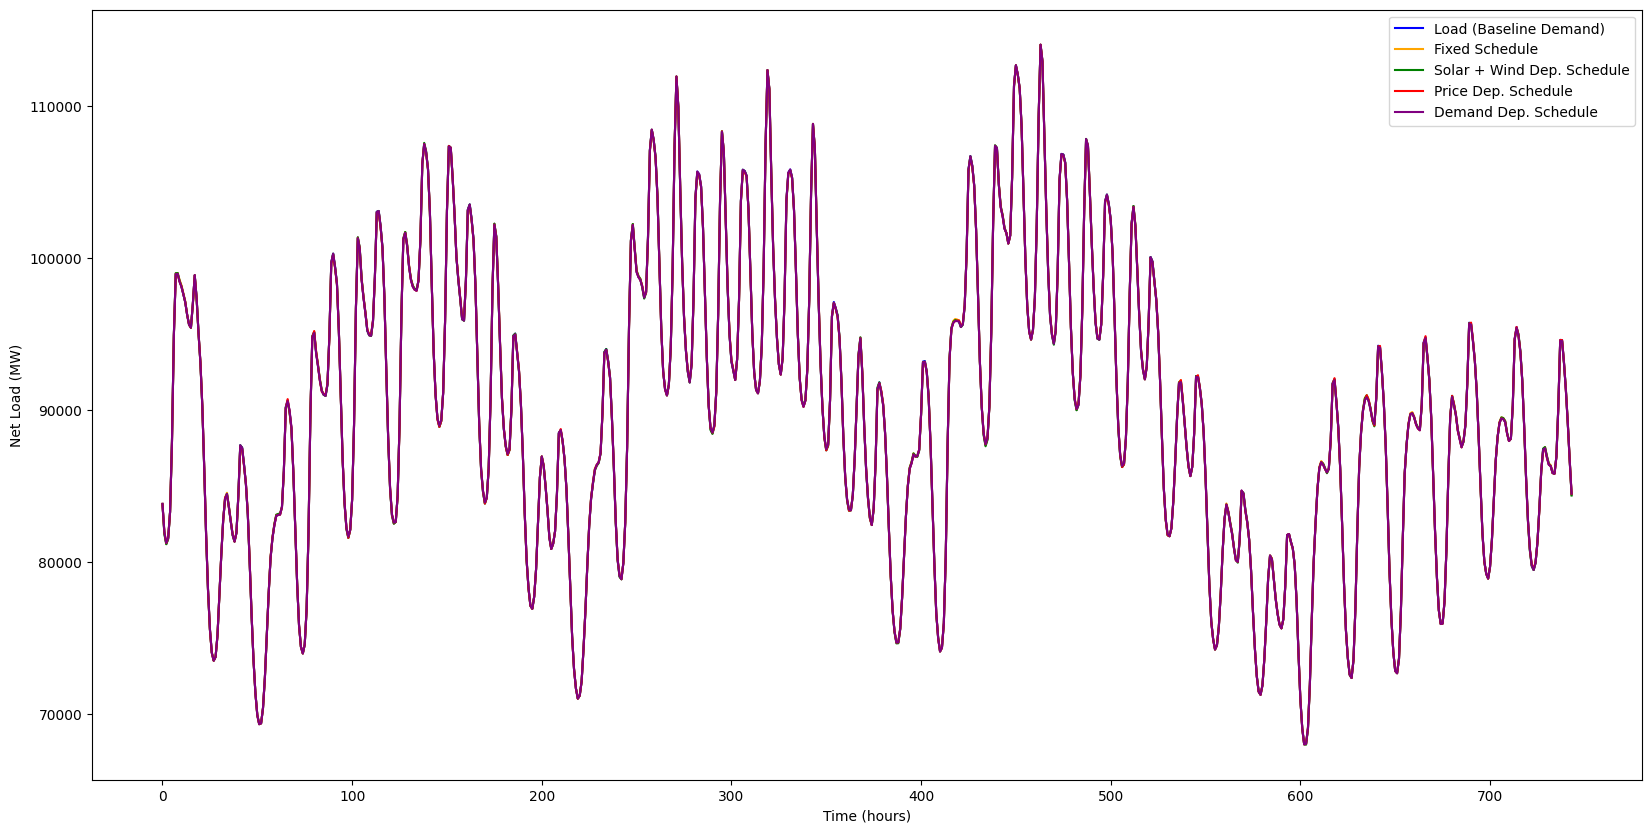

In [ ]:
#Reshape data into one row and plot data
plt.figure(figsize=(20,10))
plt.plot(df_demand.Demand_MWh, color = 'blue', label='Load (Baseline Demand)')
plt.plot(new_energy_consume_fixed, color = 'orange', label='Fixed Schedule')
plt.plot(new_energy_consume_Gen, color = 'green', label='Solar + Wind Dep. Schedule')
plt.plot(new_energy_consume_Price, color = 'red', label='Price Dep. Schedule')
plt.plot(new_energy_consume_Demand, color = 'purple', label='Demand Dep. Schedule')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Net Load (MW)')

# Show the plot
plt.show()


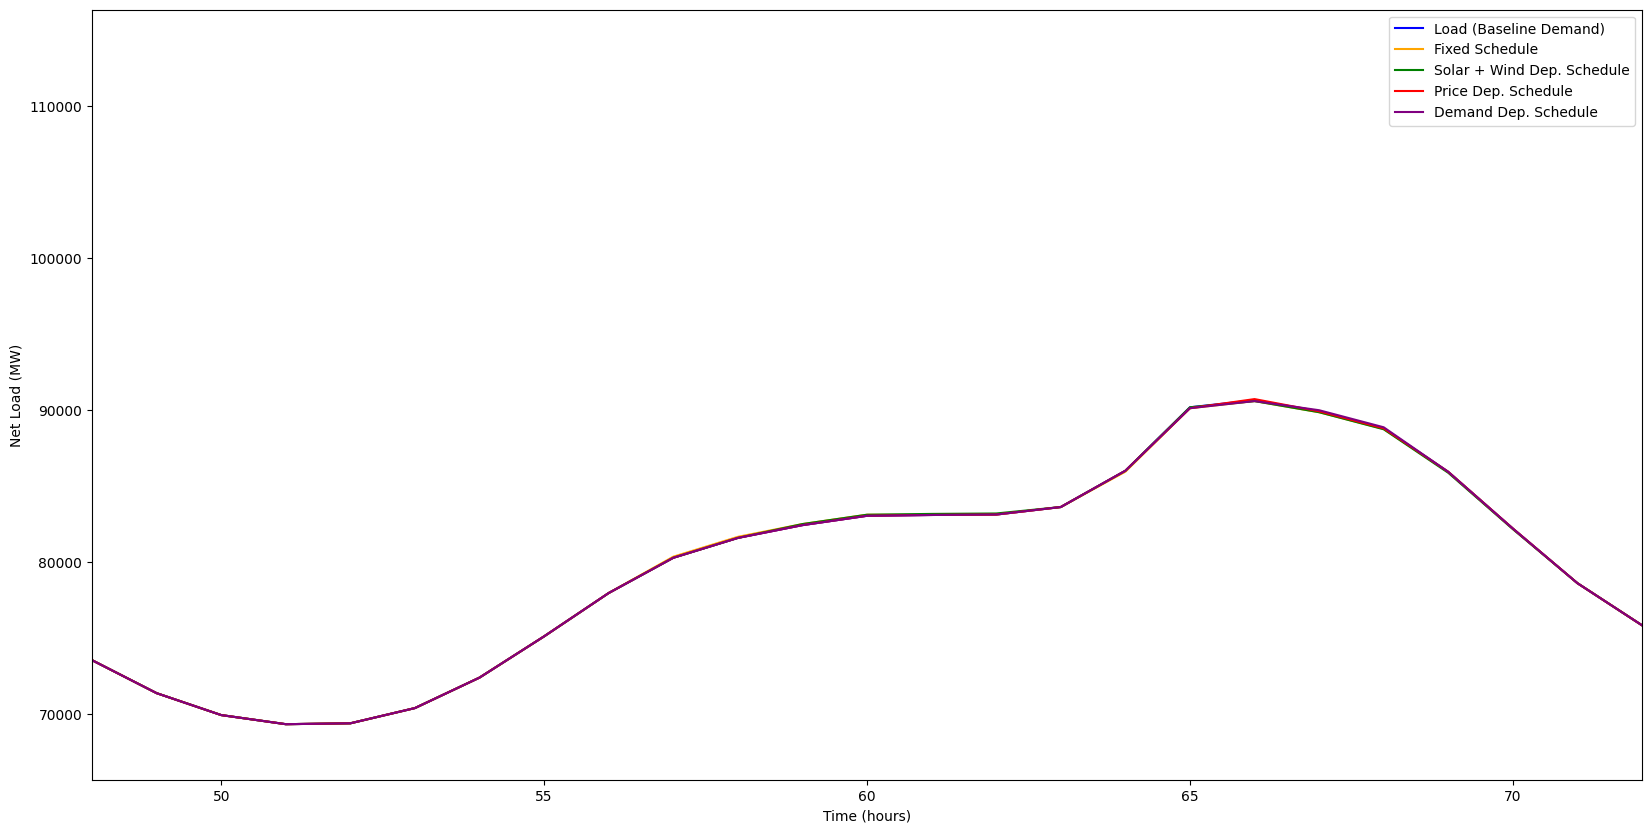

In [ ]:
# Define the start and end time for the zoomed-in period
start_time = 48  # Example start time (adjust as needed)
end_time = 72    # Example end time (adjust as needed)

# Reshape data into one row and plot data
plt.figure(figsize=(20,10))
plt.plot(df_demand.Demand_MWh, color='blue', label='Load (Baseline Demand)')
plt.plot(new_energy_consume_fixed, color='orange', label='Fixed Schedule')
plt.plot(new_energy_consume_Gen, color='green', label='Solar + Wind Dep. Schedule')
plt.plot(new_energy_consume_Price, color='red', label='Price Dep. Schedule')
plt.plot(new_energy_consume_Demand, color='purple', label='Demand Dep. Schedule')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Net Load (MW)')

# Set x-axis limits to zoom in on the specified time period
plt.xlim(start_time, end_time)

#plt.ylim(72500, 91500)

# Show the plot
plt.show()


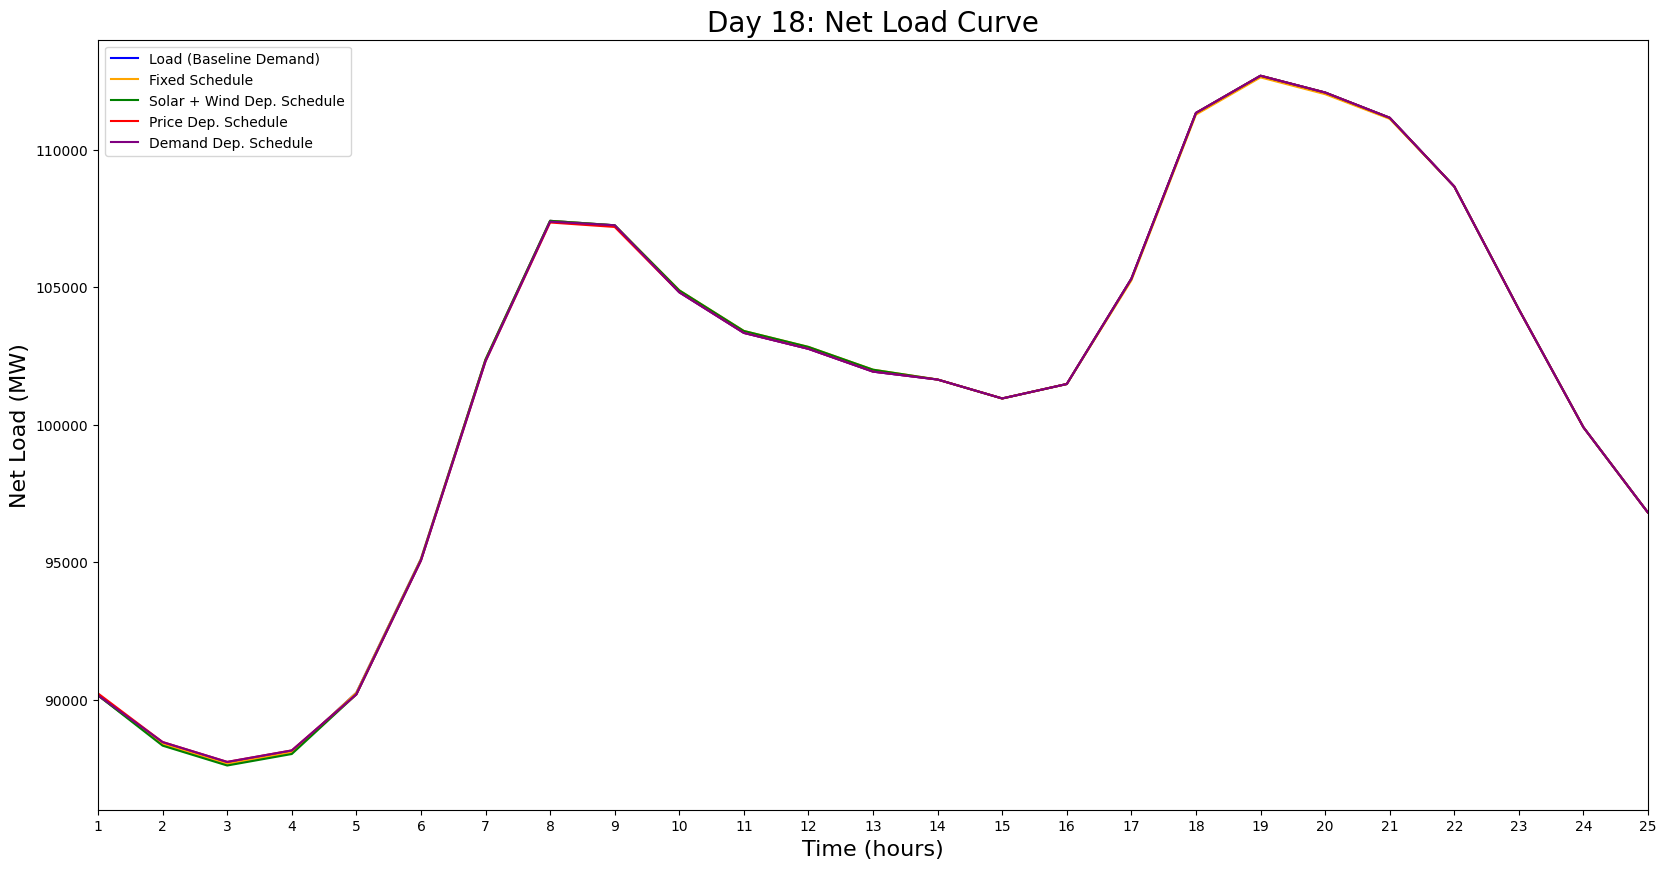

In [ ]:
# Define the start and end time for the zoomed-in period
start_time = 432  # Example start time (adjust as needed)
end_time = 456    # Example end time (adjust as needed)

# Reshape data into one row and plot data
plt.figure(figsize=(20,10))
plt.plot(df_demand.Demand_MWh, color='blue', label='Load (Baseline Demand)')
plt.plot(new_energy_consume_fixed, color='orange', label='Fixed Schedule')
plt.plot(new_energy_consume_Gen, color='green', label='Solar + Wind Dep. Schedule')
plt.plot(new_energy_consume_Price, color='red', label='Price Dep. Schedule')
plt.plot(new_energy_consume_Demand, color='purple', label='Demand Dep. Schedule')
plt.legend()
plt.xlabel('Time (hours)', fontsize=16)
plt.ylabel('Net Load (MW)', fontsize=16)
plt.title('Day 18: Net Load Curve', fontsize=20)
# Set x-axis limits to zoom in on the specified time period
plt.xlim(start_time, end_time)

# Set x-axis ticks to show numbers from 1 to 24
plt.xticks(range(start_time, end_time + 1), range(1, end_time - start_time + 2))

# Set x-axis limits to zoom in on the specified time period
plt.xlim(start_time, end_time)

plt.ylim(86000, 114000)

# Show the plot
plt.show()

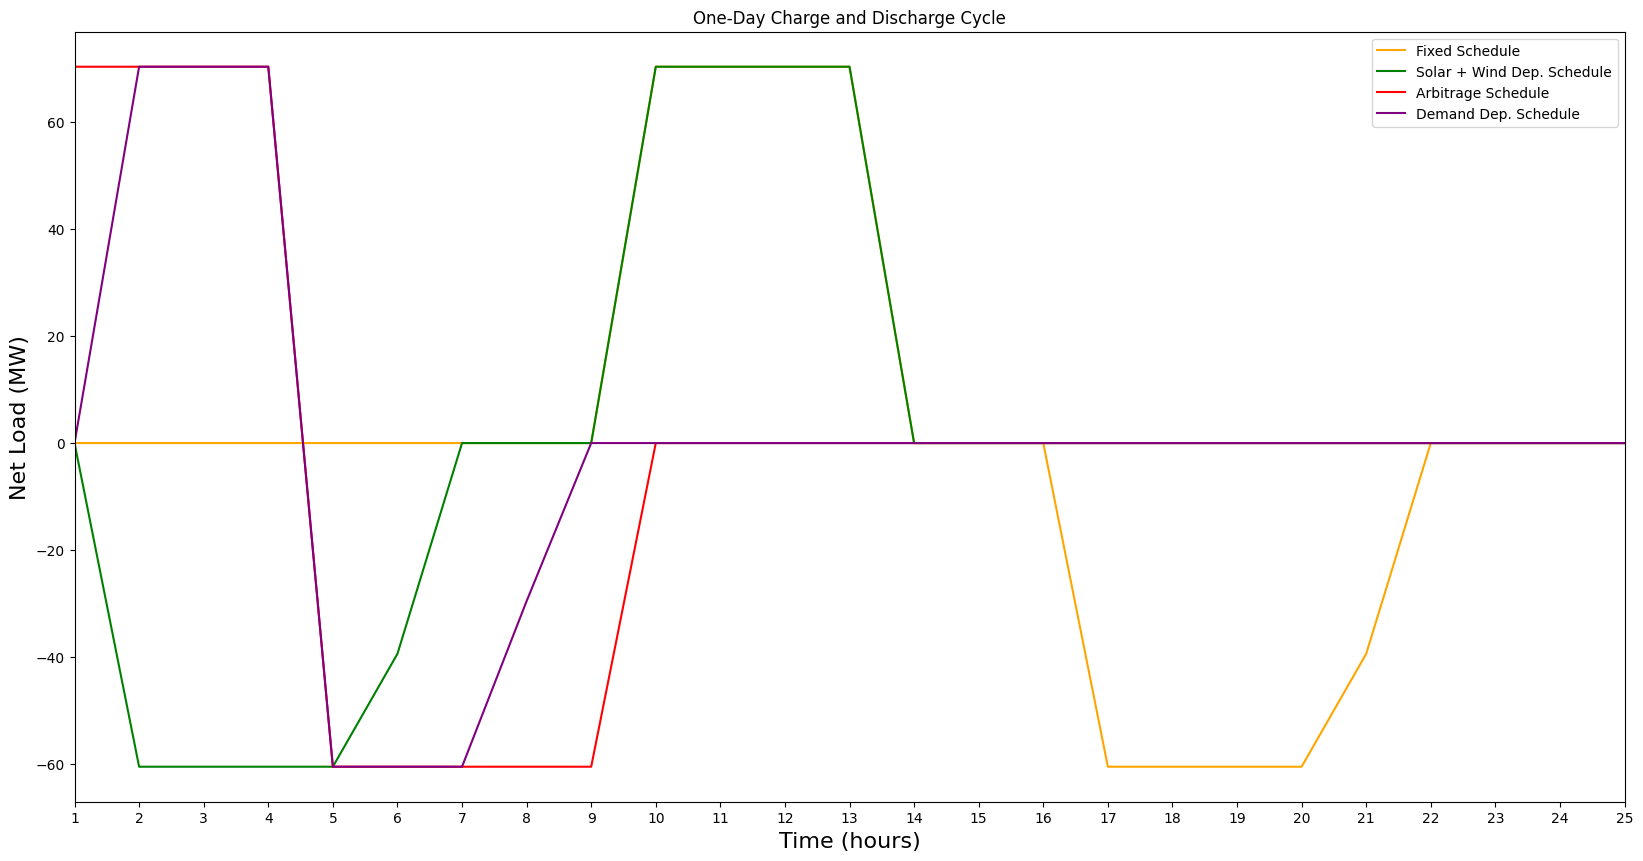

In [ ]:
# Define the start and end time for the zoomed-in period
start_time = 432  # Example start time (adjust as needed)
end_time = 456    # Example end time (adjust as needed)





# Reshape data into one row and plot data
plt.figure(figsize=(20,10))
plt.plot(fixed_charging_discharging_cycle, color='orange', label='Fixed Schedule')
plt.plot(dynamic_charging_discharging_cycle, color='green', label='Solar + Wind Dep. Schedule')
plt.plot(price_charging_discharging_cycle, color='red', label='Arbitrage Schedule')
plt.plot(demand_charging_discharging_cycle, color='purple', label='Demand Dep. Schedule')
plt.legend()
plt.xlabel('Time (hours)', fontsize=16)
plt.ylabel('Net Load (MW)', fontsize=16)
plt.title('One-Day Charge and Discharge Cycle')

# Set x-axis limits to zoom in on the specified time period
plt.xlim(start_time, end_time)

# Set x-axis ticks to show numbers from 1 to 24
plt.xticks(range(start_time, end_time + 1), range(1, end_time - start_time + 2))

#plt.ylim(91000, 114000)

# Show the plot
plt.show()

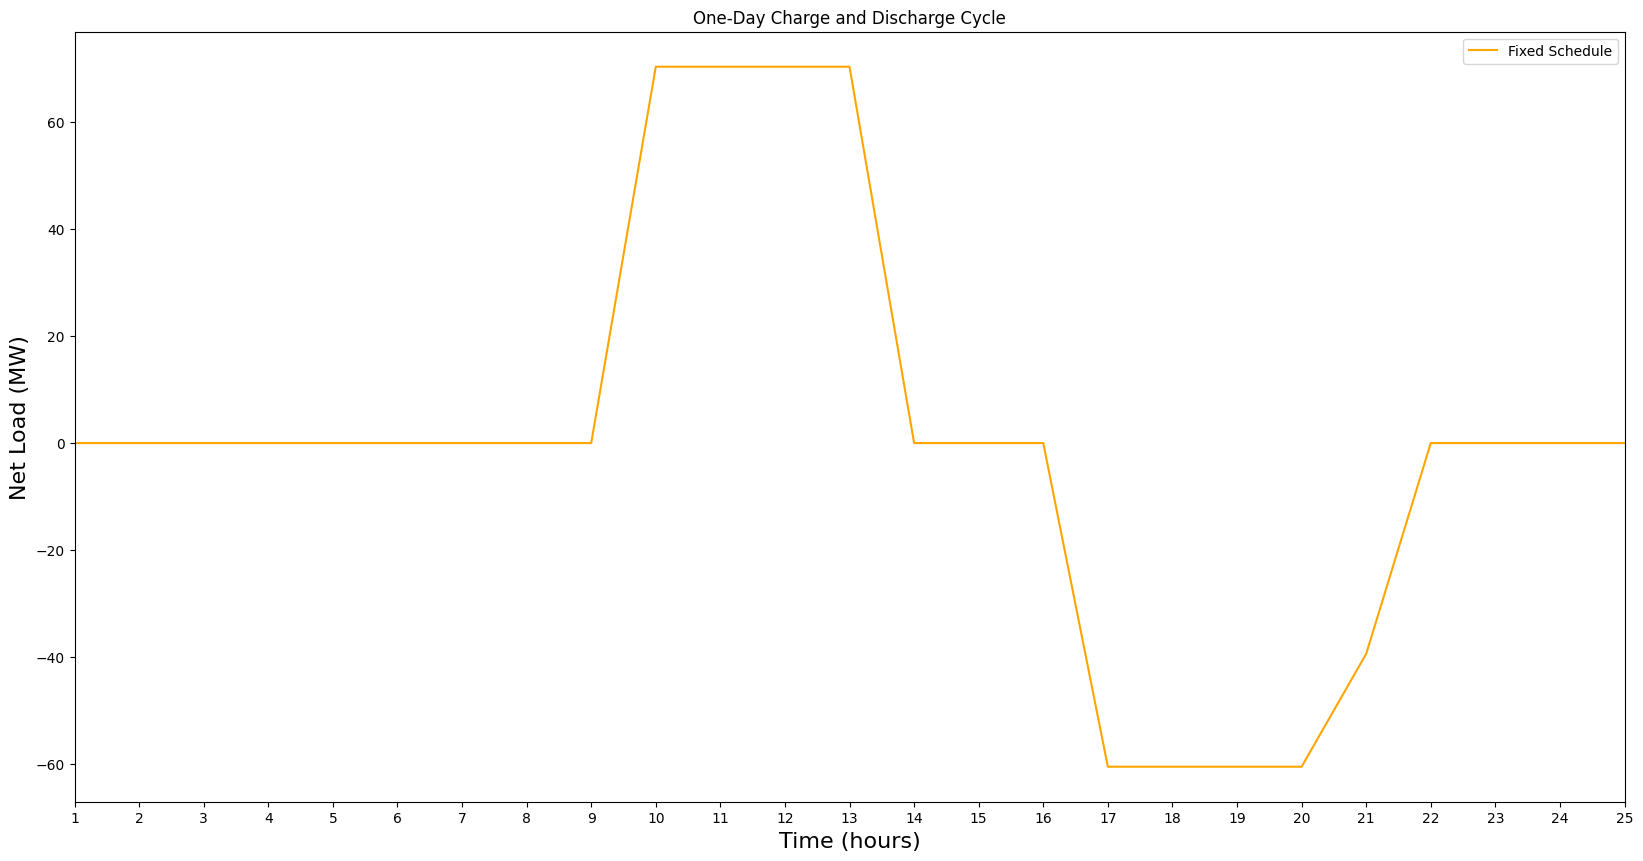

In [ ]:
# Define the start and end time for the zoomed-in period
start_time = 432  # Example start time (adjust as needed)
end_time = 456    # Example end time (adjust as needed)


# Reshape data into one row and plot data
plt.figure(figsize=(20,10))
plt.plot(fixed_charging_discharging_cycle, color='orange', label='Fixed Schedule')
plt.legend()
plt.xlabel('Time (hours)', fontsize=16)
plt.ylabel('Net Load (MW)', fontsize=16)
plt.title('One-Day Charge and Discharge Cycle Fixed')

# Set x-axis limits to zoom in on the specified time period
plt.xlim(start_time, end_time)

# Set x-axis ticks to show numbers from 1 to 24
plt.xticks(range(start_time, end_time + 1), range(1, end_time - start_time + 2))

#plt.ylim(91000, 114000)

# Show the plot
plt.show()

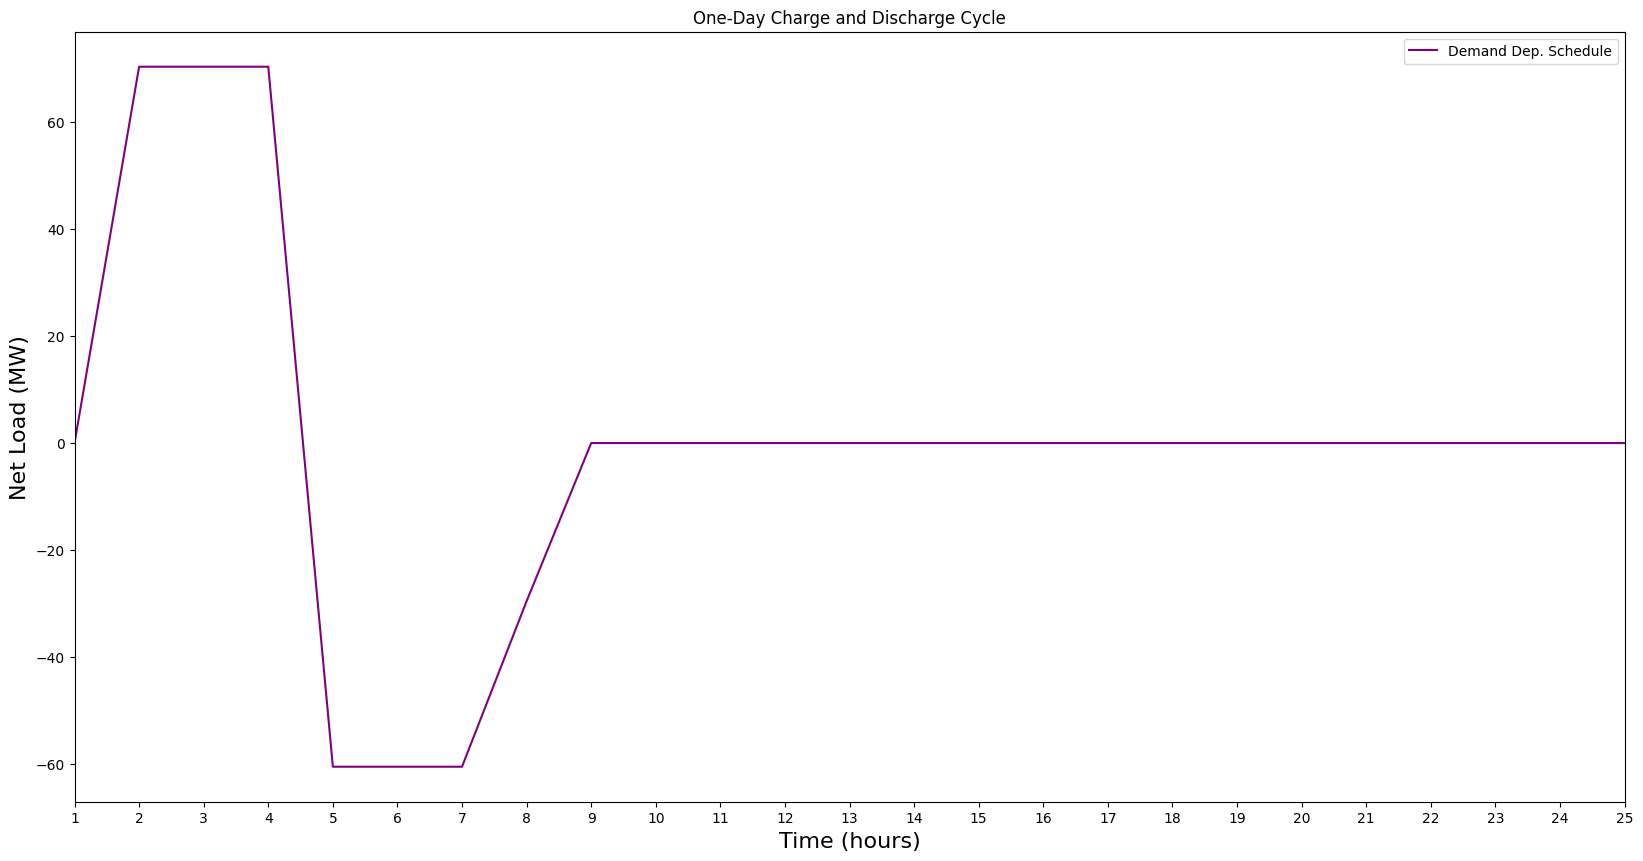

In [ ]:
# Define the start and end time for the zoomed-in period
start_time = 432  # Example start time (adjust as needed)
end_time = 456    # Example end time (adjust as needed)
# Reshape data into one row and plot data
plt.figure(figsize=(20,10))
plt.plot(demand_charging_discharging_cycle, color='purple', label='Demand Dep. Schedule')
plt.legend()
plt.xlabel('Time (hours)', fontsize=16)
plt.ylabel('Net Load (MW)', fontsize=16)
plt.title('One-Day Charge and Discharge Cycle')

# Set x-axis limits to zoom in on the specified time period
plt.xlim(start_time, end_time)

# Set x-axis ticks to show numbers from 1 to 24
plt.xticks(range(start_time, end_time + 1), range(1, end_time - start_time + 2))

#plt.ylim(91000, 114000)

# Show the plot
plt.show()

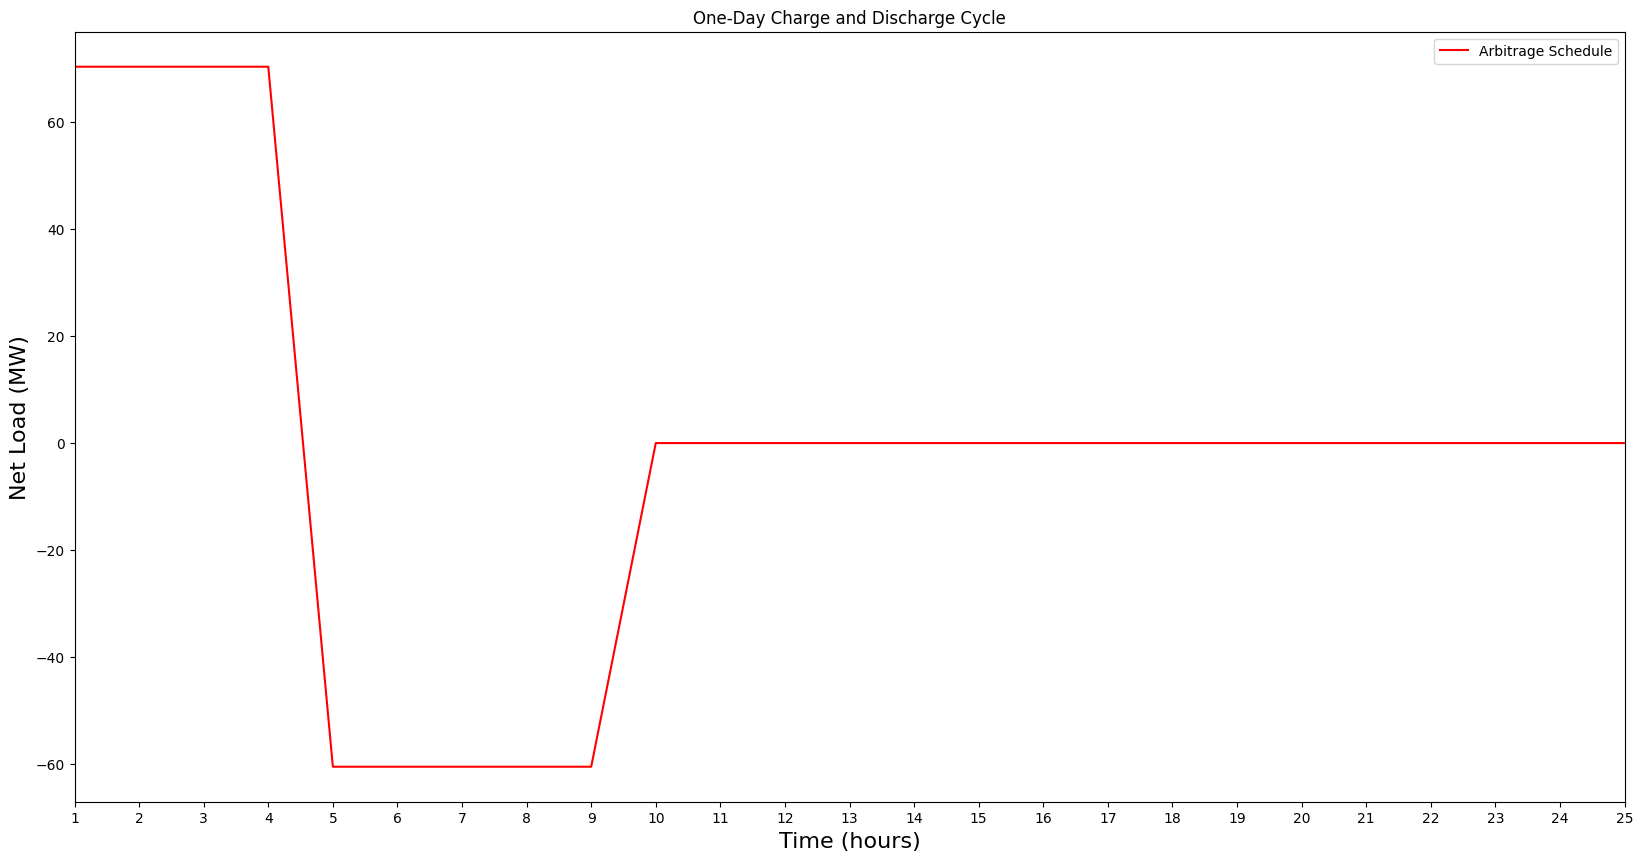

In [ ]:
# Define the start and end time for the zoomed-in period
start_time = 432  # Example start time (adjust as needed)
end_time = 456    # Example end time (adjust as needed)

# Reshape data into one row and plot data
plt.figure(figsize=(20,10))
plt.plot(price_charging_discharging_cycle, color='red', label='Arbitrage Schedule')
plt.legend()
plt.xlabel('Time (hours)', fontsize=16)
plt.ylabel('Net Load (MW)', fontsize=16)
plt.title('One-Day Charge and Discharge Cycle')

# Set x-axis limits to zoom in on the specified time period
plt.xlim(start_time, end_time)

# Set x-axis ticks to show numbers from 1 to 24
plt.xticks(range(start_time, end_time + 1), range(1, end_time - start_time + 2))

#plt.ylim(91000, 114000)

# Show the plot
plt.show()

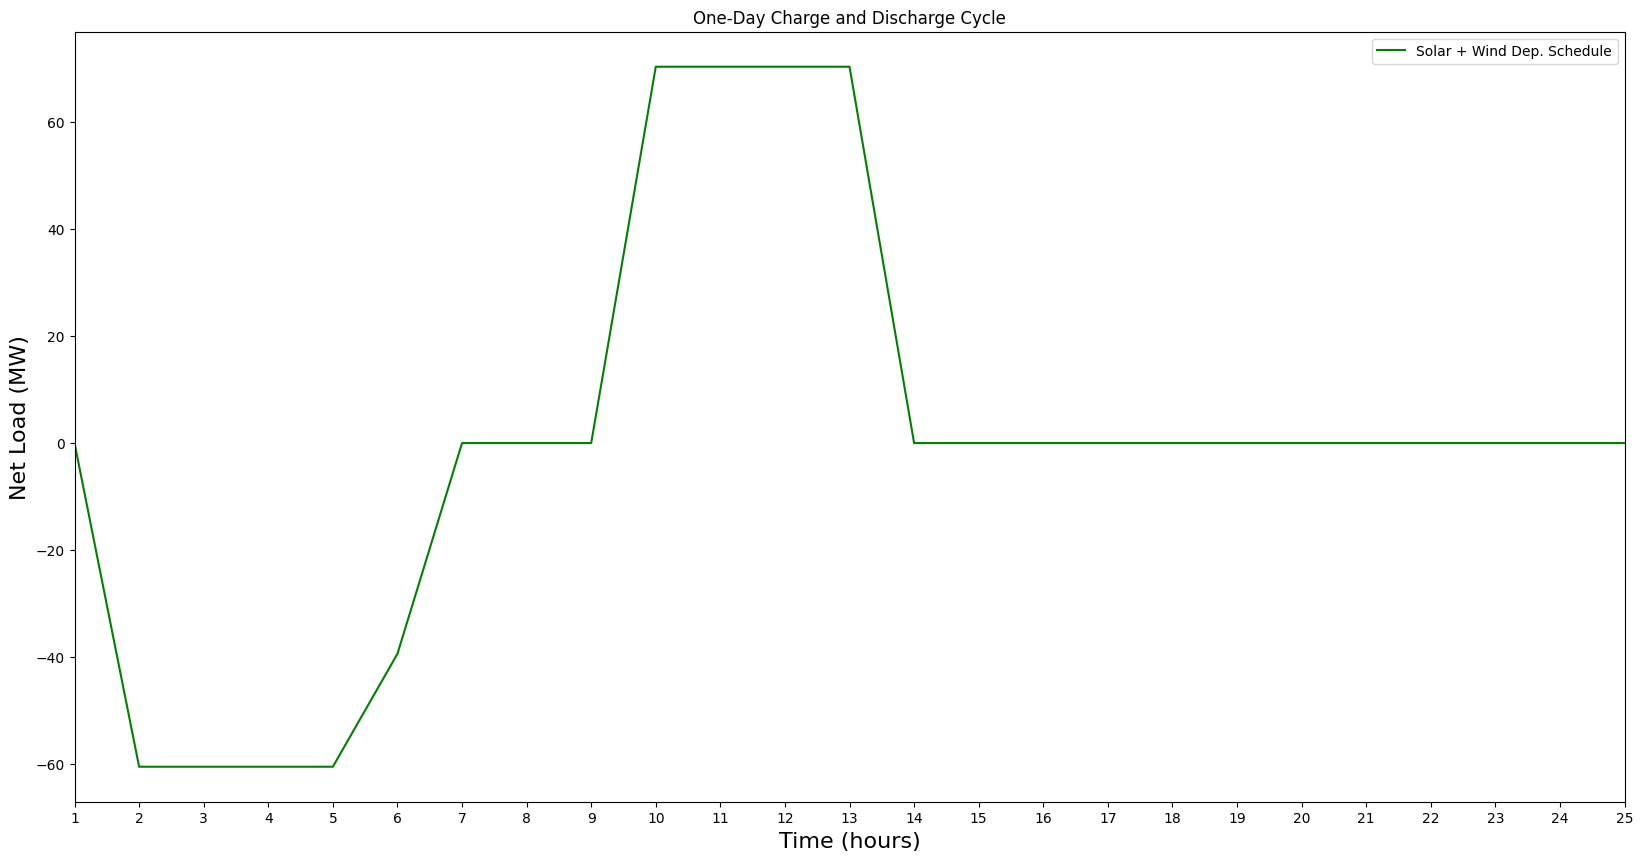

In [ ]:
# Define the start and end time for the zoomed-in period
start_time = 432  # Example start time (adjust as needed)
end_time = 456    # Example end time (adjust as needed)

# Reshape data into one row and plot data
plt.figure(figsize=(20,10))
plt.plot(dynamic_charging_discharging_cycle, color='green', label='Solar + Wind Dep. Schedule')
plt.legend()
plt.xlabel('Time (hours)', fontsize=16)
plt.ylabel('Net Load (MW)', fontsize=16)
plt.title('One-Day Charge and Discharge Cycle')

# Set x-axis limits to zoom in on the specified time period
plt.xlim(start_time, end_time)

# Set x-axis ticks to show numbers from 1 to 24
plt.xticks(range(start_time, end_time + 1), range(1, end_time - start_time + 2))

#plt.ylim(91000, 114000)

# Show the plot
plt.show()

Load Duration

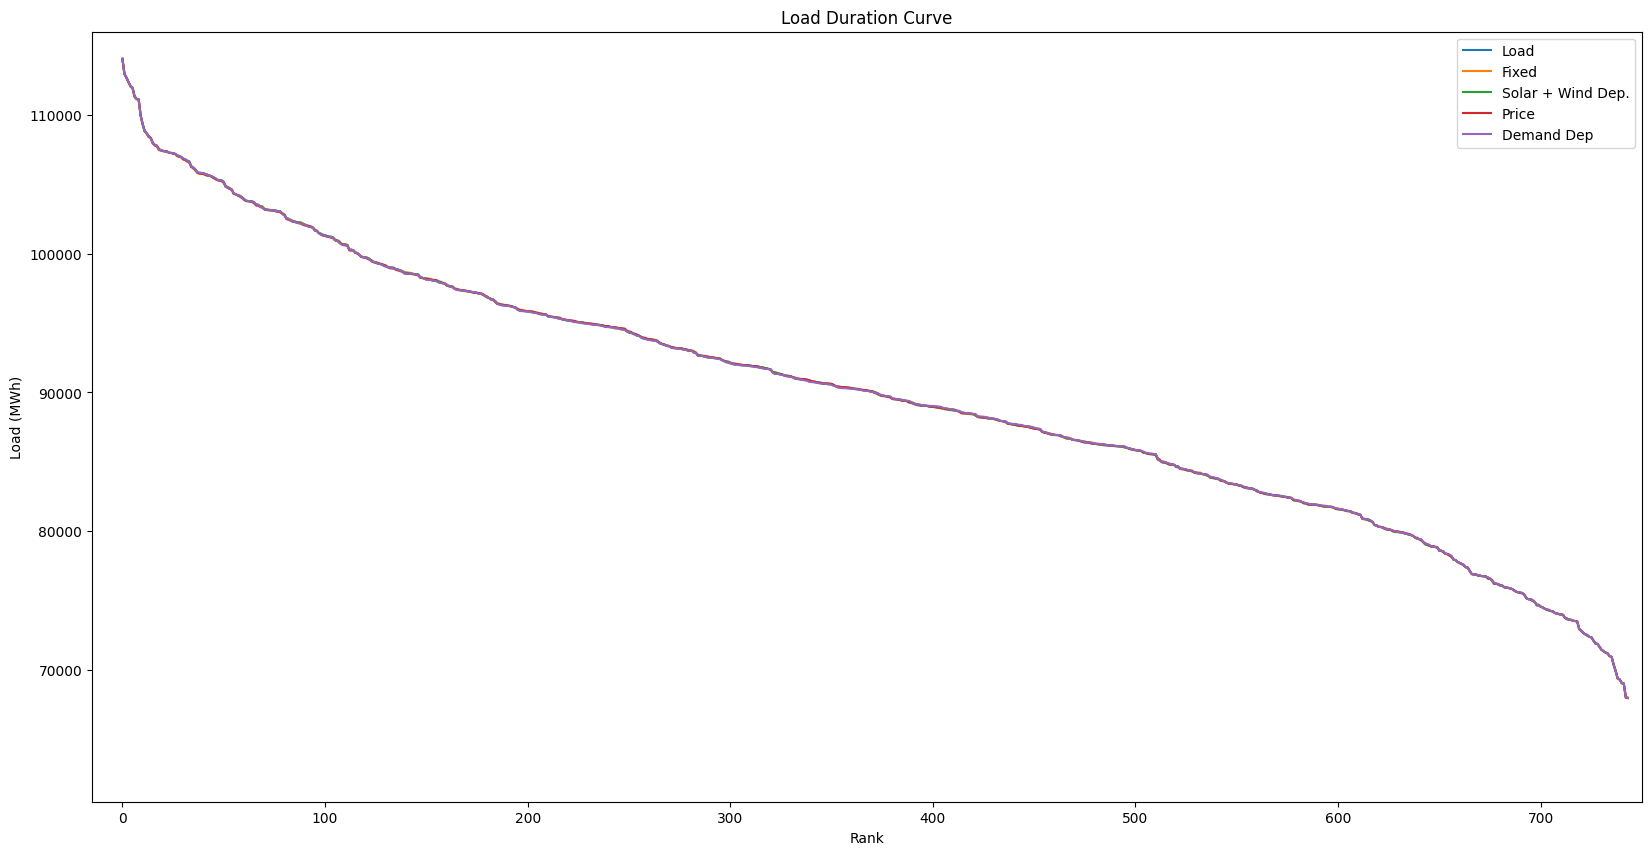

In [ ]:
load_duration([df_demand.Demand_MWh,new_energy_consume_fixed,new_energy_consume_Gen,new_energy_consume_Price,new_energy_consume_Demand],
              legend_labels=['Load', 'Fixed', 'Solar + Wind Dep.','Price', 'Demand Dep'], title='Load Duration Curve', x_label='Rank', y_label='Load (MWh)',zoom_x_start=-15,
              zoom_x_end=750, zoom_y_start=60500, zoom_y_end=116000)


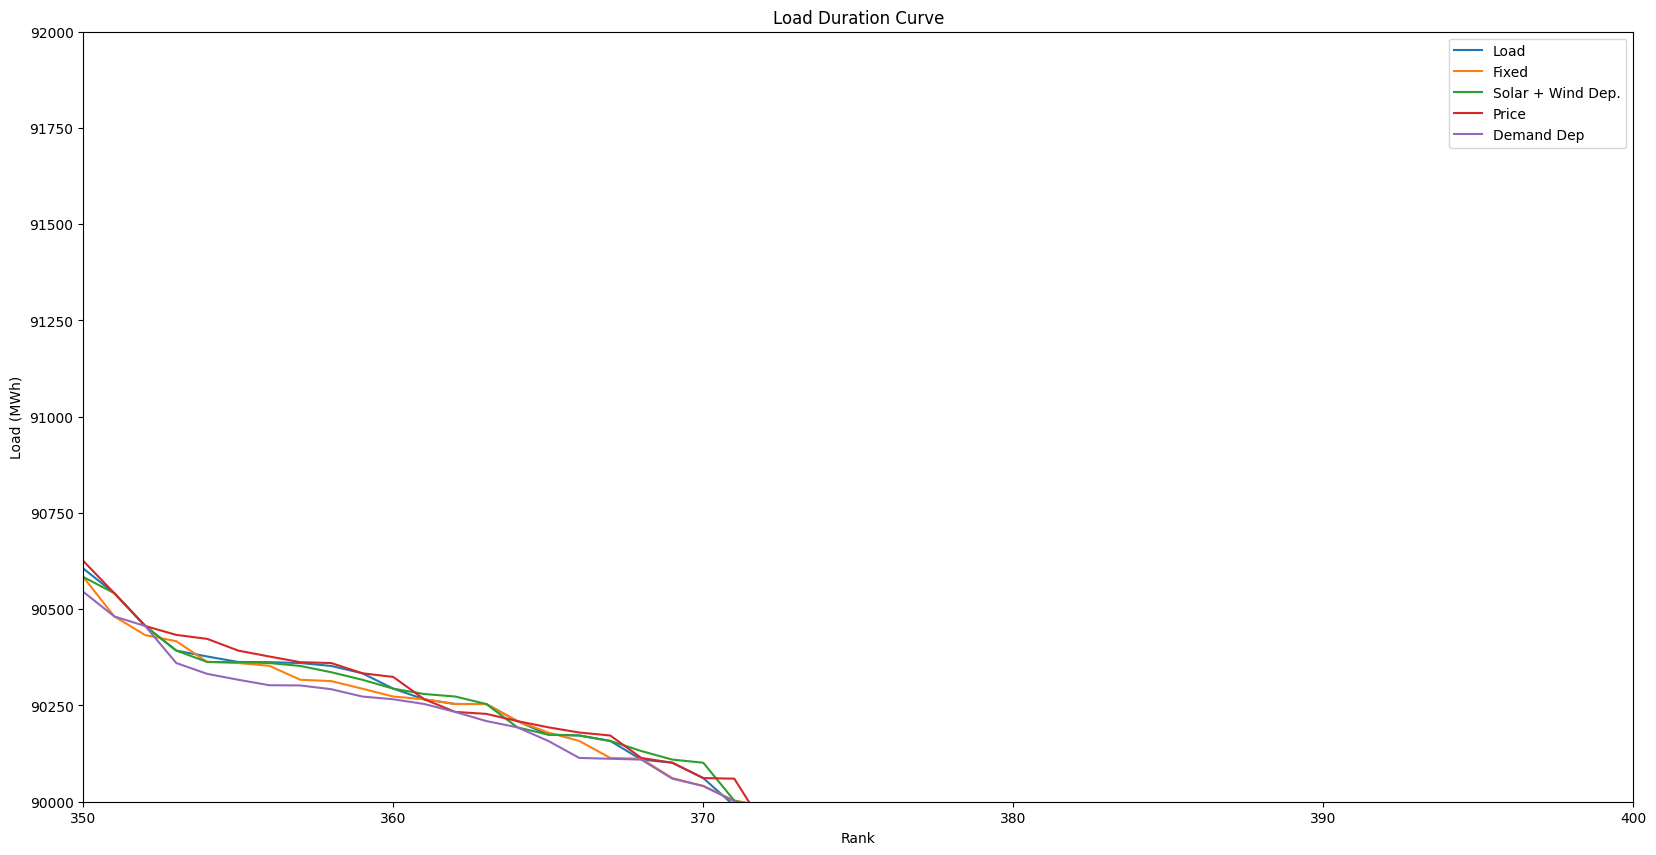

In [ ]:

load_duration([df_demand.Demand_MWh, new_energy_consume_fixed, new_energy_consume_Gen, new_energy_consume_Price, new_energy_consume_Demand],
              legend_labels=['Load', 'Fixed', 'Solar + Wind Dep.', 'Price', 'Demand Dep'],
              title='Load Duration Curve',
              x_label='Rank',
              y_label='Load (MWh)',
              zoom_x_start=350,
              zoom_x_end=400,
              zoom_y_start=90000,
              zoom_y_end=92000)

In [ ]:
#Counting the Number of hours no wind or solar is gen
# Counting the number of times wind plus solar equals 0
count_zero_generation = len(df_gen[df_gen['Solar_Generation_MWh'] + df_gen['Wind_Generation_MWh'] == 0])

# Calculating the minimum value of wind plus solar generation
min_generation = (df_gen['Solar_Generation_MWh'] + df_gen['Wind_Generation_MWh']).min()

print("Number of times wind plus solar equals 0:", count_zero_generation)
print("Minimum value of wind plus solar generation:", min_generation)

Number of times wind plus solar equals 0: 0
Minimum value of wind plus solar generation: 152


# **Emissions, Cost, Etc.** cost and emissions factor-- if spec. month or time then we can subtract the dif.

Calculate MWh

0      41617
1      37971
2      37280
3      37767
4      38677
       ...  
739    42460
740    41854
741    40283
742    40046
743    39531
Name: Tot_renew_Generation, Length: 744, dtype: int64
29356419
Load_MWh AUC: 305070728.0375
Fixed_MWh AUC: 305054026.0125
SW_MWh AUC: 305042506.1831251
price_MWh AUC: 305053319.74875003
demand_MWh AUC: 305058159.35375


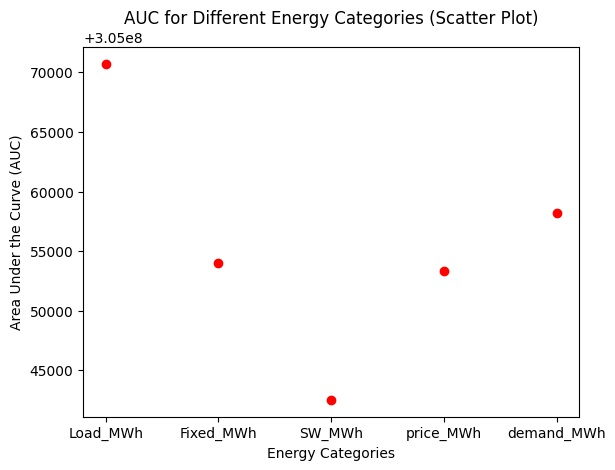

In [ ]:
########Calculate the area under the curve of renwable energy

# Calculate the total wind and solar generation
df_merged_gen_dem['Tot_renew_Generation'] = df_merged_gen_dem['Solar_Generation_MWh'] + df_merged_gen_dem['Wind_Generation_MWh'] + df_merged_gen_dem['Hydro_Generation_MWh'] + df_merged_gen_dem['Nuclear_Generation_MWh']

# Create a new DataFrame with the time and sum gen columns
df_time_and_tot_renew_gen = df_merged_gen_dem[['Timestamp_hr_ending', 'Tot_renew_Generation']]

print(df_time_and_tot_renew_gen['Tot_renew_Generation'])

renew_MWh = df_time_and_tot_renew_gen['Tot_renew_Generation'].sum() #for MWh
#renew_MWh = calculate_area(df_time_and_tot_renew_gen['Tot_renew_Generation']) #for MW
print(renew_MWh)

# Sum all values in each DataFrame and subtract Renewable energy
#Load_MWh = df_demand.Demand_MWh.sum() - renew_MWh
#Fixed_MWh = new_energy_consume_fixed.sum() - renew_MWh
#SW_MWh = new_energy_consume_Gen.sum() - renew_MWh
#price_MWh = new_energy_consume_Price.sum() - renew_MWh
#demand_MWh = new_energy_consume_Demand.sum() - renew_MWh

#calculate area under the load curve (MWh) & subtract Renewable energy
#Load_MWh = calculate_area(df_demand.Demand_MWh) - renew_MWh
#Fixed_MWh = calculate_area(new_energy_consume_fixed) - renew_MWh
#SW_MWh = calculate_area(new_energy_consume_Gen) - renew_MWh
#price_MWh = calculate_area(new_energy_consume_Price) - renew_MWh
#demand_MWh = calculate_area(new_energy_consume_Demand) - renew_MWh

# Trim renewal charge DataFrames to match the length
fixed_renew_charge = fixed_renew_charge[:len(df_demand['Demand_MWh'])]
VRE_renew_charge = VRE_renew_charge[:len(df_demand['Demand_MWh'])]
price_renew_charge = price_renew_charge[:len(df_demand['Demand_MWh'])]
demand_renew_charge = demand_renew_charge[:len(df_demand['Demand_MWh'])]

#Taking out assumed renew
Fixed_MW = np.subtract(new_energy_consume_fixed, fixed_renew_charge)
SW_MW = np.subtract(new_energy_consume_Gen, VRE_renew_charge)
price_MW = np.subtract(new_energy_consume_Price, price_renew_charge)
demand_MW = np.subtract(new_energy_consume_Demand, demand_renew_charge)

#calculate area under the load curve (MWh) & subtract Renewable energy
Load_MWh = calculate_area(df_demand.Demand_MWh) - renew_MWh
Fixed_MWh = calculate_area(Fixed_MW) - renew_MWh
SW_MWh = calculate_area(SW_MW) - renew_MWh
price_MWh = calculate_area(price_MW) - renew_MWh
demand_MWh = calculate_area(demand_MW) - renew_MWh

# Display the results
print("Load_MWh AUC:", Load_MWh)
print("Fixed_MWh AUC:", Fixed_MWh)
print("SW_MWh AUC:", SW_MWh)
print("price_MWh AUC:", price_MWh)
print("demand_MWh AUC:", demand_MWh)

# Scatter plot
labels = ['Load_MWh', 'Fixed_MWh', 'SW_MWh', 'price_MWh', 'demand_MWh']
auc_values = [Load_MWh, Fixed_MWh, SW_MWh, price_MWh, demand_MWh]

plt.scatter(labels, auc_values, color='red', marker='o')
plt.xlabel('Energy Categories')
plt.ylabel('Area Under the Curve (AUC)')
plt.title('AUC for Different Energy Categories (Scatter Plot)')
plt.show()

Calculate Emissions

In [ ]:
# Get Emissions Rate and convert to tons (US) from lbs :

em_location = df_emissions[(df_emissions.BACODE == balance_auth)]
em_rate_NOX = em_location.BANOXRTA * 0.0005
em_rate_SO2 = em_location.BASO2RTA * 0.0005
em_rate_CO2 = em_location.BACO2RTA * 0.0005
em_rate_CH4 = em_location.BACH4RTA * 0.0005
em_rate_CO2_EQU = em_location.BAC2ERTA * 0.0005
print(em_rate_CO2)


44    0.406677
Name: BACO2RTA, dtype: float64


In [ ]:
# Assuming you have the values stored in variables as mentioned
emission_rates = np.array([em_rate_NOX, em_rate_SO2, em_rate_CO2, em_rate_CH4, em_rate_CO2_EQU])
calculated_values = np.array([Load_MWh, Fixed_MWh, SW_MWh, price_MWh, demand_MWh])

result_table = {}

# Multiply each emission rate by each calculated value and assign new names
for i, rate in enumerate(emission_rates):
    for j, value in enumerate(calculated_values):
        result_table[f"Result_{i + 1}_{j + 1}"] = rate * value

# Perform element-wise multiplication for each combination
result_matrix = np.outer(emission_rates, calculated_values)

# Create a DataFrame with rows as emission rates and columns as calculated values
result_df = pd.DataFrame(result_matrix, index=['NOX', 'SO2', 'CO2', 'CH4', 'CO2_EQU'],
                         columns=['Load_MWh', 'Fixed_MWh', 'SW_MWh', 'price_MWh', 'demand_MWh'])

# Now, result_df is a DataFrame representing the table
print(result_df)


             Load_MWh     Fixed_MWh        SW_MWh     price_MWh    demand_MWh
NOX      5.643808e+04  5.643499e+04  5.643286e+04  5.643486e+04  5.643576e+04
SO2      7.474233e+04  7.473824e+04  7.473541e+04  7.473806e+04  7.473925e+04
CO2      1.240652e+08  1.240585e+08  1.240538e+08  1.240582e+08  1.240601e+08
CH4      1.052494e+04  1.052436e+04  1.052397e+04  1.052434e+04  1.052451e+04
CO2_EQU  1.247514e+08  1.247445e+08  1.247398e+08  1.247442e+08  1.247462e+08


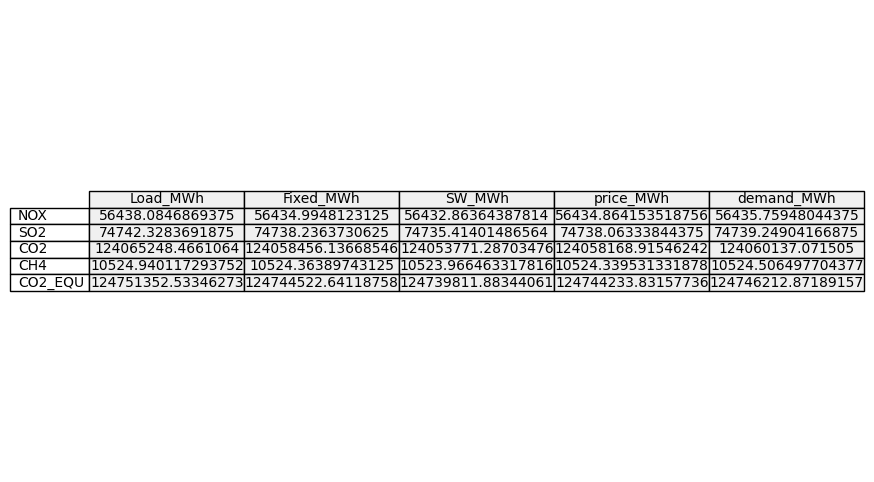

In [ ]:
# Assuming you have the values stored in variables as mentioned
emission_rates = np.array([em_rate_NOX, em_rate_SO2, em_rate_CO2, em_rate_CH4, em_rate_CO2_EQU])
calculated_values = np.array([Load_MWh, Fixed_MWh, SW_MWh, price_MWh, demand_MWh])

# Perform element-wise multiplication for each combination
result_matrix = np.outer(emission_rates, calculated_values)

# Create a DataFrame with rows as emission rates and columns as calculated values
result_df = pd.DataFrame(result_matrix, index=['NOX', 'SO2', 'CO2', 'CH4', 'CO2_EQU'],
                         columns=['Load_MWh', 'Fixed_MWh', 'SW_MWh', 'price_MWh', 'demand_MWh'])

# Plotting the table
plt.figure(figsize=(10, 6))
plt.axis('off')  # Turn off the axis

# Create a table within the plot
table = plt.table(cellText=result_df.values, colLabels=result_df.columns, rowLabels=result_df.index,
                  cellLoc='center', loc='center', colColours=['#f0f0f0']*len(result_df.columns),
                  cellColours=[['#f0f0f0']*len(result_df.columns) for _ in range(len(result_df.index))])

# Adjust the cell font size
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.show()


<ipython-input-44-b13aa90bf9a4>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  result_values_NOX[i] = result_values_NOX[i] - (Load_MWh * em_rate_NOX)


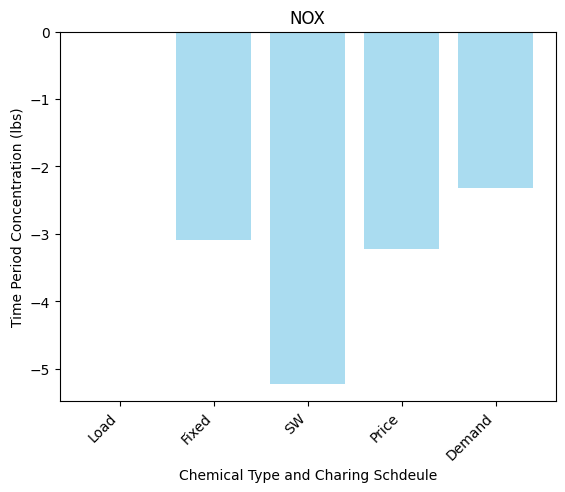

In [ ]:

# Set Arrays
emission_rates = np.array([em_rate_NOX])
calculated_values = np.array([Load_MWh, Fixed_MWh, SW_MWh, price_MWh, demand_MWh])

# Perform element-wise multiplication for each combination
result_matrix = np.outer(emission_rates, calculated_values)

# Flatten the result matrix to get a 1D array with 15 values (3 emission rates x 5 calculated values)
result_values_NOX = result_matrix.flatten()

# Use a for loop to subtract Load_MWh * em_rate_CO2 from each element in result_values_CO2
for i in range(len(result_values_NOX)):
    result_values_NOX[i] = result_values_NOX[i] - (Load_MWh * em_rate_NOX)

# Manually input names for the x-axis labels
bar_labels = ['Load', 'Fixed', 'SW', 'Price', 'Demand']

# Plotting only the bar graph for all 15 values
fig, ax = plt.subplots()

ax.bar(bar_labels, result_values_NOX, color='skyblue', alpha=0.7)

# Add labels and title
ax.set_xlabel('Chemical Type and Charing Schdeule')
ax.set_ylabel('Time Period Concentration (lbs)')
ax.set_title('NOX')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()




<ipython-input-45-e7805d5a5f4a>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  result_values_SO2[i] = result_values_SO2[i] - (Load_MWh * em_rate_SO2)


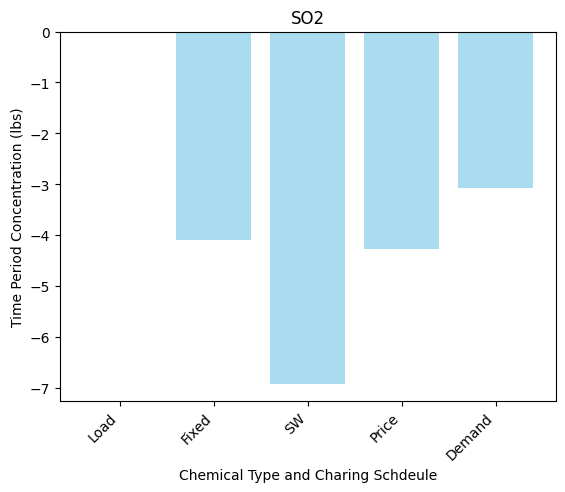

In [ ]:
# Set Arrays
emission_rates = np.array([em_rate_SO2])
calculated_values = np.array([Load_MWh, Fixed_MWh, SW_MWh, price_MWh, demand_MWh])

# Perform element-wise multiplication for each combination
result_matrix = np.outer(emission_rates, calculated_values)

# Flatten the result matrix to get a 1D array with 15 values (3 emission rates x 5 calculated values)
result_values_SO2 = result_matrix.flatten()

# Use a for loop to subtract Load_MWh * em_rate_CO2 from each element in result_values_CO2
for i in range(len(result_values_SO2)):
    result_values_SO2[i] = result_values_SO2[i] - (Load_MWh * em_rate_SO2)

# Manually input names for the x-axis labels
bar_labels = ['Load', 'Fixed', 'SW', 'Price', 'Demand']

# Plotting only the bar graph for all 15 values
fig, ax = plt.subplots()

ax.bar(bar_labels, result_values_SO2, color='skyblue', alpha=0.7)

# Add labels and title
ax.set_xlabel('Chemical Type and Charing Schdeule')
ax.set_ylabel('Time Period Concentration (lbs)')
ax.set_title('SO2')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

<ipython-input-46-2a66adaa5b64>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  result_values_CH4[i] = result_values_CH4[i] - (Load_MWh * em_rate_CH4)


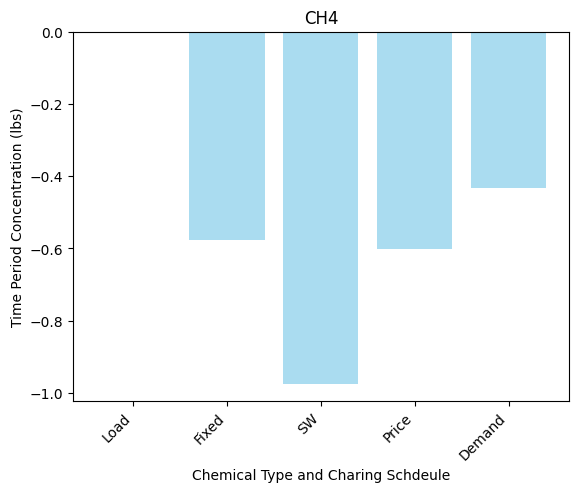

In [ ]:
# Set Arrays
emission_rates = np.array([em_rate_CH4])
calculated_values = np.array([Load_MWh, Fixed_MWh, SW_MWh, price_MWh, demand_MWh])

# Perform element-wise multiplication for each combination
result_matrix = np.outer(emission_rates, calculated_values)

# Flatten the result matrix to get a 1D array with 15 values (3 emission rates x 5 calculated values)
result_values_CH4 = result_matrix.flatten()

# Use a for loop to subtract Load_MWh * em_rate_CO2 from each element in result_values_CO2
for i in range(len(result_values_CH4)):
    result_values_CH4[i] = result_values_CH4[i] - (Load_MWh * em_rate_CH4)

# Manually input names for the x-axis labels
bar_labels = ['Load', 'Fixed', 'SW', 'Price', 'Demand']

# Plotting only the bar graph for all 15 values
fig, ax = plt.subplots()

ax.bar(bar_labels, result_values_CH4, color='skyblue', alpha=0.7)

# Add labels and title
ax.set_xlabel('Chemical Type and Charing Schdeule')
ax.set_ylabel('Time Period Concentration (lbs)')
ax.set_title('CH4')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

<ipython-input-47-bd8735849e5b>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  result_values_CO2[i] = result_values_CO2[i] - (Load_MWh * em_rate_CO2)


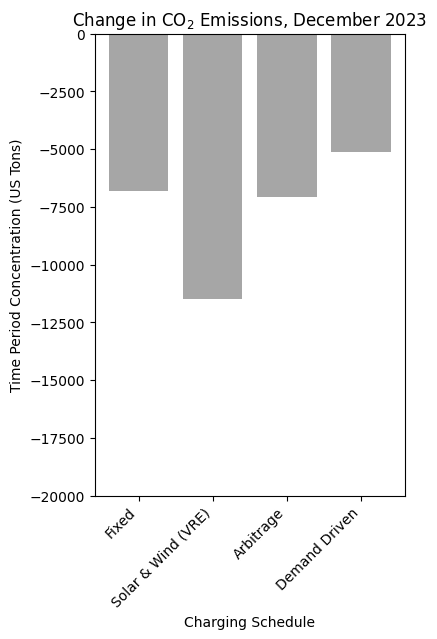

In [ ]:
# Set Arrays
emission_rates = np.array([em_rate_CO2])
calculated_values = np.array([Fixed_MWh, SW_MWh, price_MWh, demand_MWh])

# Perform element-wise multiplication for each combination
result_matrix = np.outer(emission_rates, calculated_values)

# Flatten the result matrix to get a 1D array with 15 values (3 emission rates x 5 calculated values)
result_values_CO2 = result_matrix.flatten()

# Use a for loop to subtract Load_MWh * em_rate_CO2 from each element in result_values_CO2
for i in range(len(result_values_CO2)):
    result_values_CO2[i] = result_values_CO2[i] - (Load_MWh * em_rate_CO2)

# Manually input names for the x-axis labels
bar_labels = [ 'Fixed', 'Solar & Wind (VRE)', 'Arbitrage', 'Demand Driven']

# Plotting only the bar graph for all 15 values
fig, ax = plt.subplots(figsize=(4, 6))

ax.bar(bar_labels, result_values_CO2, color='grey', alpha=0.7)

# Add labels and title
ax.set_xlabel('Charging Schedule')
ax.set_ylabel('Time Period Concentration (US Tons)')
ax.set_title('Change in CO$_2$ Emissions, December 2023')
ax.set_ylim(-20000, 0)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()


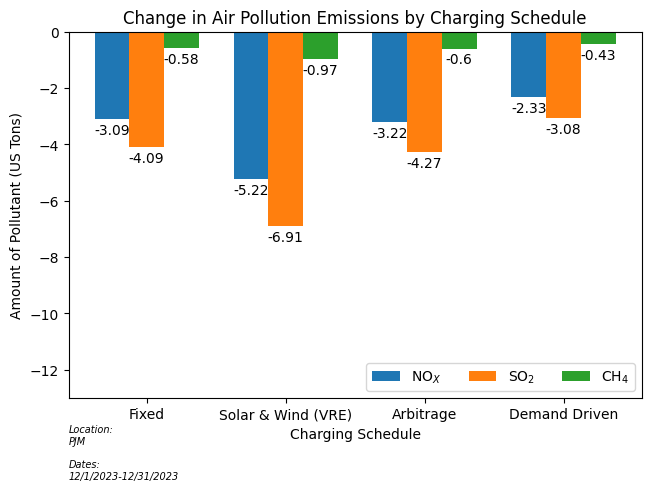

In [ ]:
species = ( 'Fixed', 'Solar & Wind (VRE)', 'Arbitrage', 'Demand Driven')
penguin_means = {
    'NO$_X$': (result_values_NOX),
    'SO$_2$': (result_values_SO2),
    'CH$_4$': (result_values_CH4),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement[-4:], width, label=attribute)

    # Manually rounding significant figures
    rounded_values = [round(val, 2) for val in measurement[-4:]]

    # Adding bar labels with rounded values
    ax.bar_label(rects, labels=rounded_values, padding=3)
    multiplier += 1

info_text = f'Location:\n{balance_auth}\n\nDates:\n{dates_of_data}'

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Amount of Pollutant (US Tons)')
ax.set_xlabel('Charging Schedule')
ax.set_title('Change in Air Pollution Emissions by Charging Schedule')
ax.set_xticks(x + width, species)
ax.legend(loc='lower right', ncols=3)
ax.set_ylim(-13, 0)
# Add a note under the graph
ax.text(0, -0.15, info_text, transform=ax.transAxes, ha='left', va='center', fontsize=7, style='italic')


plt.show()

# Cost & Net Benefit

In [ ]:
#Social Cost of Carbon
s_cost_CO2_load = em_rate_CO2_EQU * Load_MWh * cost_of_carbon *(1/2000)

print(s_cost_CO2_load)

44    3.181159e+06
Name: BAC2ERTA, dtype: float64
